## Imports

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib import cm
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, MultipleLocator
%matplotlib inline

## Set directory

In [2]:
os.chdir('../.')

# set data path
data_path = 'data/processed/'

## Default plotting style

In [7]:
# set default style
style = './notebooks/style.py'

palette12 = [
    '#011959', '#0f395f', '#165062', '#27635f',
    '#48714f', '#6d7c3b', '#97882c', '#c49138',
    '#eb9a60', '#fca995', '#fdbac7', '#faccfa'
]
palette9 = [
    '#011959', '#165062',
    '#48714f', '#6d7c3b', '#97882c', '#c49138',
    '#eb9a60', '#fca995',  '#faccfa'
]

palette9c = [
    '#e3342f', '#f6993f', '#ffed4a', '#38c172',
    '#4dc0b5', '#3490dc', '#6574cd', '#9561e2', 
    '#f66d9b'
]

palette3c= [
    '#e3342f', '#808080', '#808080', '#808080',
    '#808080', '#808080', '#808080', '#808080',
    '#f66d9b'
]

# set size for inline polots
mpl.rcParams['figure.dpi'] = 200

plt.style.use(style)
sns.color_palette(palette12)

[(0.00392156862745098, 0.09803921568627451, 0.34901960784313724),
 (0.058823529411764705, 0.2235294117647059, 0.37254901960784315),
 (0.08627450980392157, 0.3137254901960784, 0.3843137254901961),
 (0.15294117647058825, 0.38823529411764707, 0.37254901960784315),
 (0.2823529411764706, 0.44313725490196076, 0.30980392156862746),
 (0.42745098039215684, 0.48627450980392156, 0.23137254901960785),
 (0.592156862745098, 0.5333333333333333, 0.17254901960784313),
 (0.7686274509803922, 0.5686274509803921, 0.2196078431372549),
 (0.9215686274509803, 0.6039215686274509, 0.3764705882352941),
 (0.9882352941176471, 0.6627450980392157, 0.5843137254901961),
 (0.9921568627450981, 0.7294117647058823, 0.7803921568627451),
 (0.9803921568627451, 0.8, 0.9803921568627451)]

# Visualise processed files
  
## Templates

- https://barabasi.com/f/972.pdf
- https://www.nature.com/articles/s41586-022-05222-x
- https://www.nature.com/articles/s41586-022-05543-x
- https://github.com/rougier/scientific-visualization-book/blob/master/code/scales-projections/scales-log-log.py 
- https://twitter.com/DKThomp/status/1637093122306965504

## Process transaction_df

In [8]:
transactions_data = pd.read_csv(Path(
    data_path+'201204-201703-service-transactions-processed-2.csv'
))

In [9]:
transactions_df = transactions_data.drop(
    columns=transactions_data.iloc[:, [0,1,2,3,5,6,7,8,9]].columns
)

transactions_df = transactions_df.drop(
    columns=transactions_df.iloc[:, list(range(2,37,2))]
)

In [10]:
def transform_dataframe(input_df):
    # Change the input DataFrame to long format
    long_df = pd.melt(
        input_df, 
        id_vars='Servicetype', 
        value_vars=list(input_df.columns[1:]), 
        var_name='Time', 
        value_name='Volume', 
        ignore_index=False
    )

    # Convert 'Time' and 'Volume' columns to numeric
    long_df[['Time', 'Volume']] = long_df[['Time', 'Volume']].apply(pd.to_numeric)
    
    # Set 'Servicetype' column as a categorical variable
    long_df = long_df.astype({'Servicetype': 'category'})
    
    # Group by 'Servicetype' and 'Time' columns and sum 'Volume' values
    pivoted_df = long_df.groupby(['Servicetype', 'Time'])['Volume'].sum().unstack(level=1).reset_index()

    # Change 'pivoted_df' back to long format
    pivoted_df = pd.melt(
        pivoted_df, 
        id_vars='Servicetype', 
        value_vars=list(pivoted_df.columns[1:]), 
        var_name='Time', 
        value_name='Volume', 
        ignore_index=False
    )

    # Convert 'Time' column to datetime format
    pivoted_df['Time'] = pd.to_datetime(pivoted_df['Time'], format='%Y%m')
    
    return pivoted_df


def exclude_passenger_arrivals(df, val=129900000.0):
    # Check if passenger arrivals are in df
    if df['201703'].max() == 129900000.0:
        # Find the index of the row with the highest value in the '201703' column
        max_index = df['201703'].idxmax()

        # Drop the row with the highest value
        df = df.drop(max_index)

    return df

In [11]:
volume_df = transform_dataframe(transactions_df)

In [12]:
transactions_df_wo_passenger = exclude_passenger_arrivals(transactions_df)
volume_df_wo_passenger = transform_dataframe(transactions_df_wo_passenger)

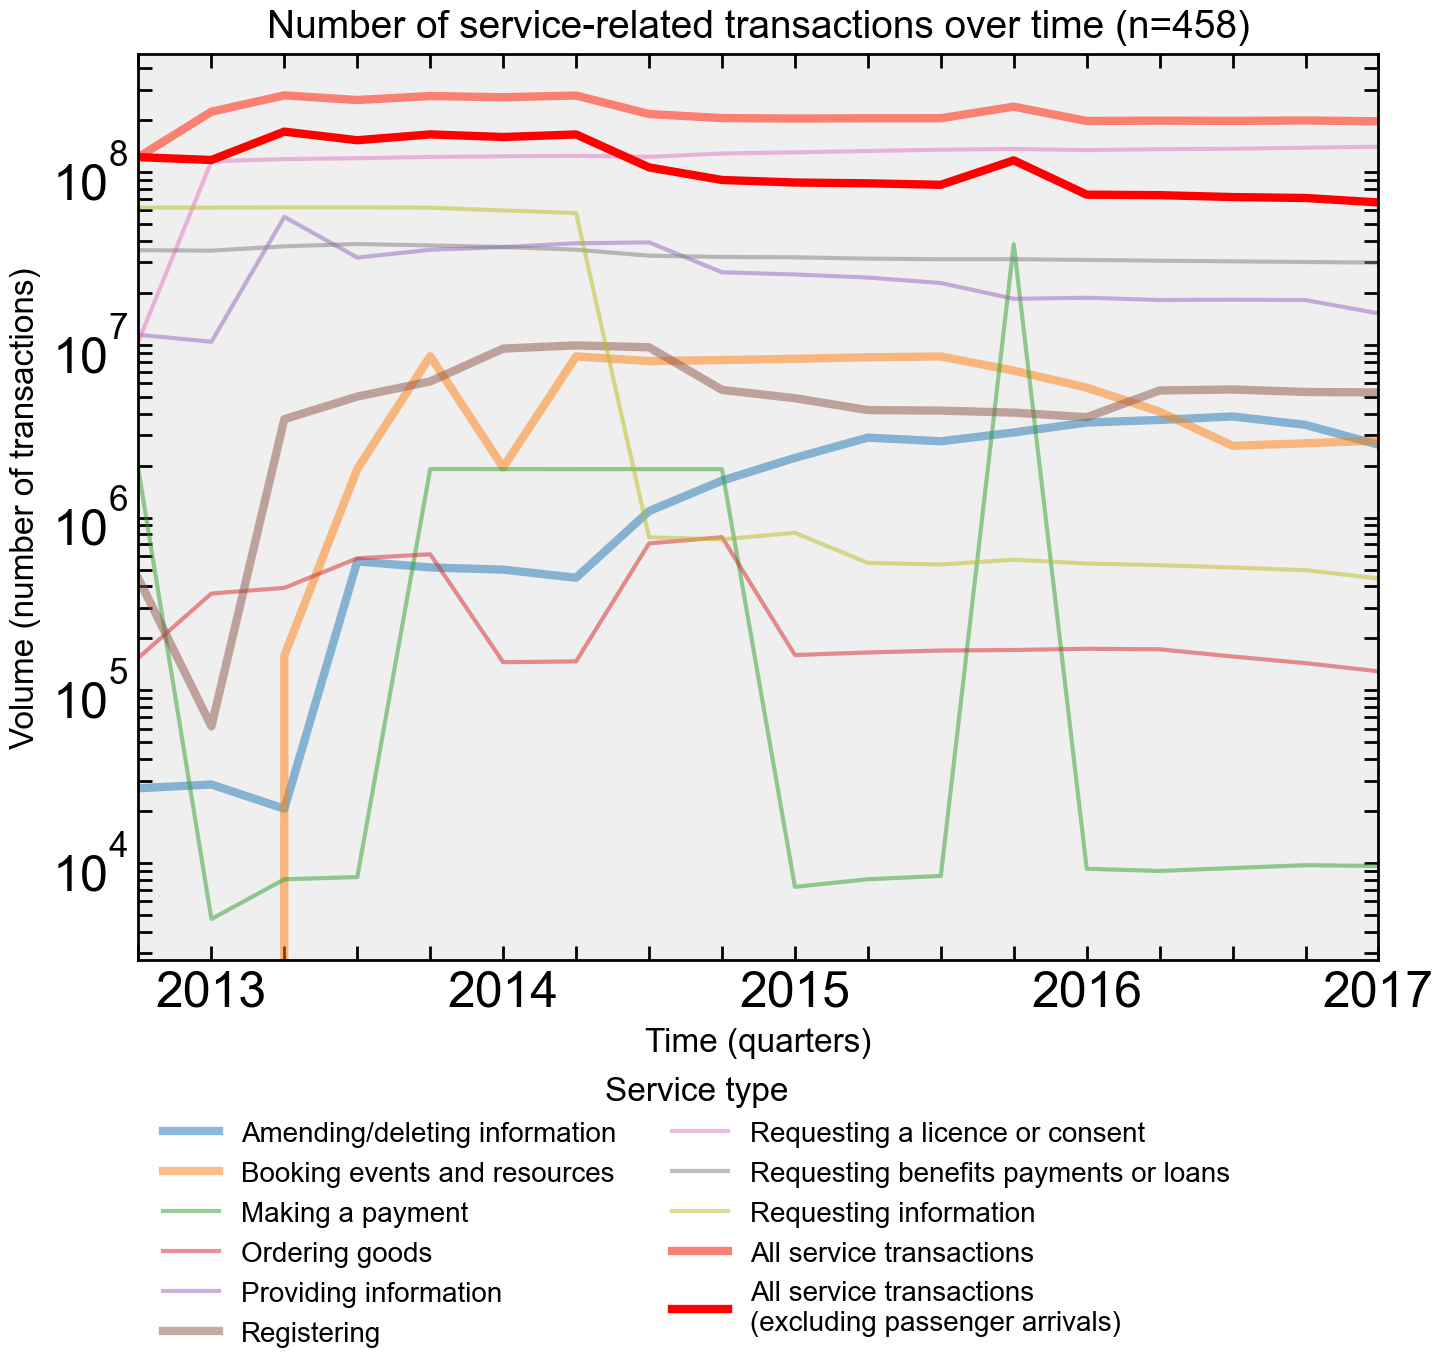

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker


# Set the font to Helvetica
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Create a new figure with a white background
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

# Group by Servicetype and Time and plot lines for each Servicetype
grouped = volume_df.groupby('Servicetype')
for i, (name, group) in enumerate(grouped):
    if name in ['Amending/deleting information', 'Registering', 'Booking events and resources']:
        # Increase line width for 'Amending/deleting information' line
        group.plot(x='Time', y='Volume', ax=ax, label=name, alpha=0.5, linewidth=3)
    else:
        group.plot(x='Time', y='Volume', ax=ax, label=name, alpha=0.5, linewidth=1.5)

# Calculate and plot the sum of Volume across all Servicetypes
sum_volume = volume_df.groupby('Time')['Volume'].sum()
sum_volume.plot(ax=ax, label='All service transactions', linestyle='-', linewidth=3, color='salmon')

# Calculate and plot the sum of Volume across all Servicetypes excluding passenger arrivals
sum_volume = volume_df_wo_passenger.groupby('Time')['Volume'].sum()
sum_volume.plot(ax=ax, label='All service transactions \n(excluding passenger arrivals)', linestyle='-', linewidth=3, color='red')

# Customize the plot
ax.set_xlabel('Time (quarters)', fontsize=12)
ax.set_ylabel('Volume (number of transactions)', fontsize=12)
ax.set_title('Number of service-related transactions over time (n=458)', fontsize=14)
ax.grid(True)

ax.set_facecolor('#efefef')
ax.grid(False)  # Remove gridlines

# Increase font size for readability on a PowerPoint presentation
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend outside the plot
ax.legend(fontsize=10, loc='upper left', title='Service type', title_fontsize=12, bbox_to_anchor=(0, -.1), ncol=2)

# Set the log scale on the y-axis
plt.yscale("log")

# Modify the spines
ax.spines['top'].set_color('black')  # Remove top spine
ax.spines['right'].set_color('black')  # Remove right spine
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)

# Add major and minor ticks facing inwards
plt.tick_params(
    axis='both',
    which='both',
    direction='in',
    top=True,
    right=True,
    bottom=True,
    left=True,
    labelsize=18,
    width=1,
    length=5
)

# Display the plot
plt.show()

### Descriptive statistics

In [10]:
# Multiply by quarter
transactions_df_wo_passenger['201703'].sum() * 4

266745292.0

# Misc Figures

In [258]:
volume_df_wo_passenger.loc[volume_df_wo_passenger['Time'] == '2017-03-01T00:00:00.000000000'].sort_values(by='Volume')

Servicetype       Time      Volume
2                       Making a payment 2017-03-01      9622.0
3                         Ordering goods 2017-03-01    128879.0
8                 Requesting information 2017-03-01    444201.0
0          Amending/deleting information 2017-03-01   2640018.0
1           Booking events and resources 2017-03-01   2789778.0
5                            Registering 2017-03-01   5298740.0
6        Requesting a licence or consent 2017-03-01  10277694.0
4                  Providing information 2017-03-01  15207793.0
7  Requesting benefits payments or loans 2017-03-01  29889598.0

In [259]:
volume_df_wo_passenger.loc[volume_df_wo_passenger['Servicetype'] == 'Requesting a licence or consent']

Servicetype       Time      Volume
6  Requesting a licence or consent 2012-12-01  10465444.0
6  Requesting a licence or consent 2013-03-01   9227693.0
6  Requesting a licence or consent 2013-06-01  12392241.0
6  Requesting a licence or consent 2013-09-01  11907284.0
6  Requesting a licence or consent 2013-12-01  12106580.0
6  Requesting a licence or consent 2014-03-01  11945652.0
6  Requesting a licence or consent 2014-06-01  11907057.0
6  Requesting a licence or consent 2014-09-01  12214736.0
6  Requesting a licence or consent 2014-12-01  12715242.0
6  Requesting a licence or consent 2015-03-01  12935257.0
6  Requesting a licence or consent 2015-06-01  13697697.0
6  Requesting a licence or consent 2015-09-01  14092349.0
6  Requesting a licence or consent 2015-12-01  13857880.0
6  Requesting a licence or consent 2016-03-01  10524269.0
6  Requesting a licence or consent 2016-06-01  10709721.0
6  Requesting a licence or consent 2016-09-01  10330127.0
6  Requesting a licence or consent 2016-12-01  10344176.0
6  Requesting a licence or consent 2017-03-01  10277694.0

# TRY THE ONE BELOW

https://twitter.com/DKThomp/status/1637093122306965504

## Domains and Websites

In [29]:
websites_data = pd.read_csv(Path(data_path+'201202-201809-central-government-websites.csv'))

In [30]:
websites_df = websites_data[~websites_data['URL'].str.contains(".gov.uk").fillna(False)]

In [31]:
websites_df = websites_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0']).groupby(['Year']).count()

In [32]:
websites_df = websites_df.reset_index()

In [33]:
domains_data = pd.read_csv(Path(data_path+'201210-202303-govuk-domain-names-processed.csv'))

domains_df = domains_data.groupby(['Year']).count()

domains_df = domains_df.reset_index()

### Redo this plot to make the difference more interesting

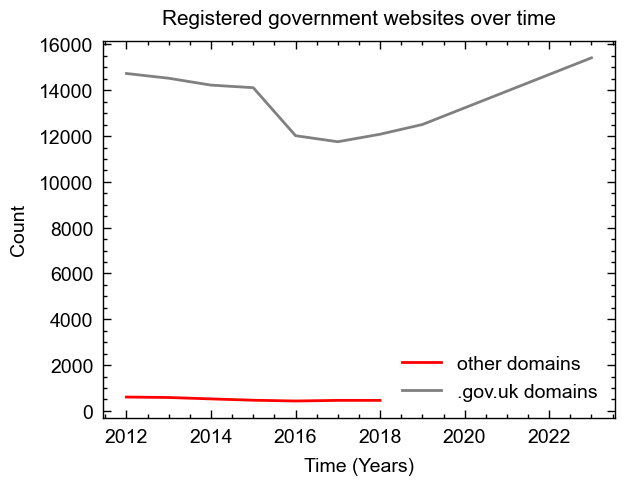

In [34]:
sns.lineplot(data=websites_df, x="Year", y="URL", color='red')

sns.lineplot(data=domains_df, x="Year", y="Domain_name", color='gray')

plt.title('Registered government websites over time', fontsize=7.5);
plt.ylabel('Count')
plt.xlabel('Time (Years)')
# plt.ylim([0, 4500])

plt.legend(['other domains', '.gov.uk domains'])

# plt.savefig('src/visualisation/websites.png')

### investigate the data above!

## Unique visitors

#### 2012

In [420]:
visits2012_data = pd.read_csv(Path(data_path+'201104-201203-govuk-unique-visitors-processed.csv'))

visits2012_data.columns = [i.replace('_', '') for i in visits2012_data.columns]

visits12_df = visits2012_data.dropna(how='any')

visits12_df['visits'] = visits12_df.sum(axis=1, numeric_only=True)

visits12_df = visits12_df.loc[:, ['URL', 'visits']].sort_values('visits', ascending=False)

visits12_df.iloc[0, 1] = visits12_df.iloc[0, 1] + visits12_df.iloc[1, 1]

visits12_df.drop(3, inplace=True)

visits12_df = visits12_df.reset_index().drop(columns='index')

/var/folders/5f/f4nt1g8x77ggbhbbvwpth89c0000gr/T/ipykernel_73987/2868818079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visits12_df['visits'] = visits12_df.sum(axis=1, numeric_only=True)


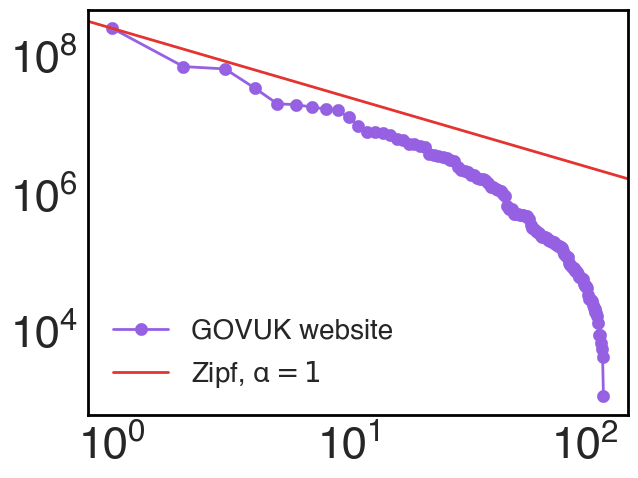

In [892]:
n = len(visits12_df)

ranks = range(1, n+1)
visits12_df['rank'] = ranks
freqs = list(visits12_df.visits)

xs = ranks[0], ranks[-1]
ys = freqs[0], freqs[-1]

figure = plt.figure()

plt.rcParams["font.family"] = "Helvetica"

ax = plt.subplot()
line1, = ax.plot(ranks, freqs, 
         linestyle="-", color='#9561e2', fillstyle='full',
         marker="o", markersize=1.6, 
         markeredgewidth=3,
         label='GOVUK website')
line2 = ax.axline((1, ys[0]), slope=-1, color='#e3342f', label='Zipf, \u03B1$=1$')

ax.set_xlabel('')
ax.set_ylabel('', fontsize=16)
# ax.set_title("Visits to GOVUK websites (2012)", size=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)  # Remove gridlines

# ax.grid(False, "minor", color="0.85", linewidth=0.50, zorder=-20)
# ax.grid(False, "major", color="0.65", linewidth=0.75, zorder=-10)

ax.tick_params(axis="y", direction="in", which='both')
ax.tick_params(axis="x", direction="in", which='both')

plt.legend(
    handles=[line1, line2], frameon=False, fancybox=False, loc='lower left',
    facecolor='white', framealpha=1, edgecolor='black', fontsize=10,
)

ax.tick_params(axis='both', labelsize=16)

# Modify the spines
ax.spines['top'].set_color('black')  # Remove top spine
ax.spines['right'].set_color('black')  # Remove right spine
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)

plt.tight_layout()
# plt.savefig("./src/visualisation/fig1-govuk-websites-log-log.pdf")
plt.show()

## Vists comparison

#### 2022

In [36]:
visits2022_data = pd.read_excel(Path(data_path+'202110-202209-govuk-unique-visitors-processed.xlsx')) 

visits_data = visits2022_data[['Page', 'Unique clicks']]

visits_data = visits_data.dropna(subset=['Unique clicks'], how='any')

visits_data.rename(columns={'Unique clicks': 'visits','Page': 'page'},
                   inplace=True)

visits22_df = visits_data.sort_values('visits', ascending=False)

n = len(visits22_df)

ranks = range(1, n+1)
visits22_df['rank'] = ranks
freqs = list(visits22_df.visits)

xs = ranks[0], ranks[-1]
ys = freqs[0], freqs[-1]

AttributeError: module 'matplotlib.pyplot' has no attribute 'spines'

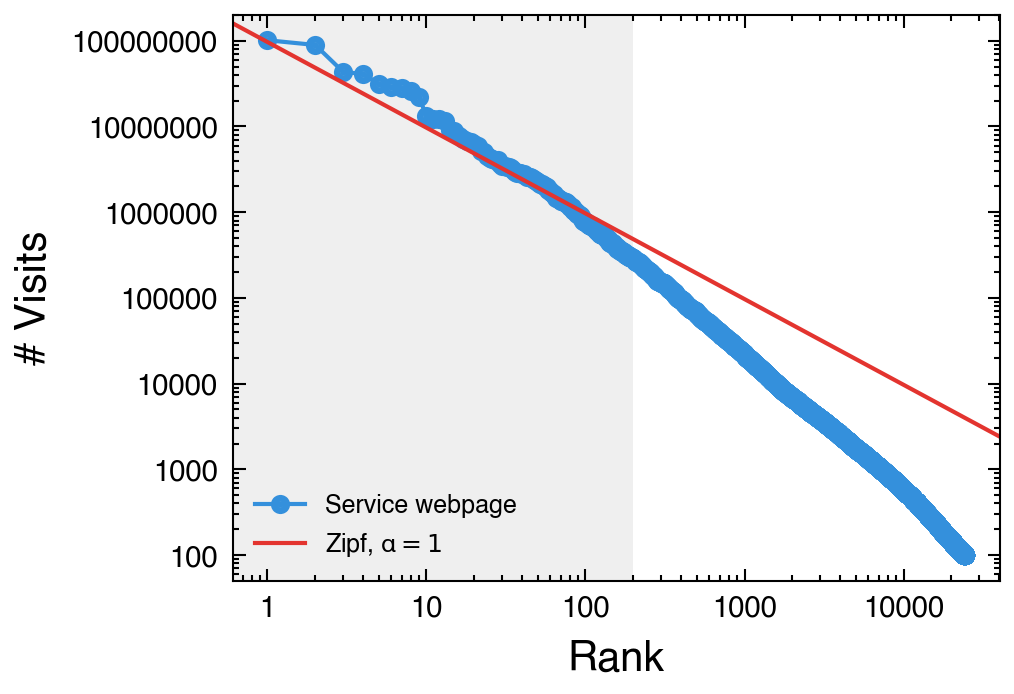

In [37]:
figure = plt.figure(dpi=300)

plt.rcParams["font.family"] = "Helvetica"

ax = plt.subplot()
line1, = ax.plot(ranks, freqs, 
         linestyle="-", color='#3490dc', fillstyle='full',
         marker="o", markersize=1.6, 
         markeredgewidth=3,
         label='Service webpage')
line2 = ax.axline((1, 96845562), slope=-1, color='#e3342f', label='Zipf, \u03B1$=1$')

ax.set_xlabel('Rank', fontsize=10)
ax.set_ylabel('# Visits', fontsize=10)
ax.set_title("", size=9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(False)  # Remove gridlines


# ax.grid(False, "minor", color="0.85", linewidth=0.50, zorder=-20)
# ax.grid(False, "major", color="0.65", linewidth=0.75, zorder=-10)

ax.tick_params(axis="y", direction="in", which='both')
ax.tick_params(axis="x", direction="in", which='both')

plt.legend(
    handles=[line1, line2], frameon=False, fancybox=False, loc='lower left',
    facecolor='white', framealpha=1, edgecolor='black', fontsize=6,
)

plt.axvspan(0, 200, facecolor='#EFEFEF')

# Set the log scale on the y-axis
plt.yscale("log")
plt.xscale("log")
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y))
)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(x),0)))).format(x))
)

# Modify the spines
plt.spines['top'].set_color('black')  # Remove top spine
plt.spines['right'].set_color('black')  # Remove right spine
plt.spines['left'].set_linewidth(1)
plt.spines['left'].set_color('black')
plt.spines['bottom'].set_linewidth(1)
plt.spines['bottom'].set_color('black')
plt.spines['right'].set_linewidth(1)
plt.spines['top'].set_linewidth(1)

ax.set_xticklabels(fontsize=16
                  )

plt.show()
# plt.savefig("./src/visualisation/fig1-govuk-visits-log-log.pdf")

##### Cumulative count

- Another thing to plot is cumulative count, i.e. for rank 1 plot just the original frequency, for rank2, the sum of ranks 1 and 2, and so on. This plot allows us to see how rapidly the occurrences accounted for by the top N ranks approach the total occurrences in the data

In [75]:
visits22_df['cum_sum'] = visits22_df['visits'].cumsum()
visits22_df['cum_perc'] = 100*visits22_df['cum_sum']/visits22_df['visits'].sum()

cum_perc = list(visits22_df.cum_perc)
cum_sum = list(visits22_df.cum_perc)

NameError: name 'ticker' is not defined

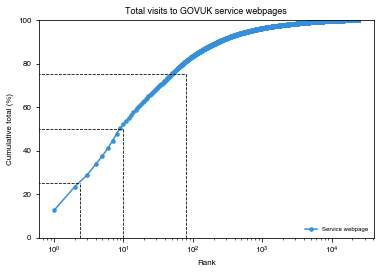

In [108]:
figure = plt.figure()

plt.rcParams["font.family"] = "Helvetica"

ax = plt.subplot()
line1, = ax.plot(ranks, cum_perc, 
         linestyle="-", color='#3490dc', fillstyle='full',
         marker="o", markersize=1.6, 
         markeredgewidth=3,
        label='Service webpage'
        )

ax.set_xscale('log')
ax.set_ylim(0,100)

ax.hlines(y=25, xmin=0, xmax=2.4, linewidth=.8, color='black', linestyle='--')
ax.vlines(x=2.4, ymin=0, ymax=25, linewidth=.8, color='black', linestyle='--')

ax.hlines(y=50, xmin=0, xmax=10, linewidth=.8, color='black', linestyle='--')
ax.vlines(x=10, ymin=0, ymax=50, linewidth=.8, color='black', linestyle='--')

ax.hlines(y=75, xmin=0, xmax=80, linewidth=.8, color='black', linestyle='--')
ax.vlines(x=80, ymin=0, ymax=75, linewidth=.8, color='black', linestyle='--')

ax.set_title("Total visits to GOVUK service webpages", size=9)
ax.set_ylabel('Cumulative total (%)', fontsize=8)
ax.set_xlabel('Rank', fontsize=8)
ax.tick_params(axis='both', labelsize=8)

plt.legend(
    handles=[line1], frameon=False, fancybox=False, loc='lower right',
    facecolor='white', framealpha=1, edgecolor='black', fontsize=6,
)


plt.xscale("log")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(x),0)))).format(x))
)


plt.tight_layout()
# plt.savefig("./src/visualisation/fig1-govuk-visits-cum_per.pdf")

- Get statistics similar to table in this [article](https://www.arteuna.com/talleres/lab/ediciones/libreria/Glottometrics-zipf.pdf#page=148)

In [159]:
visits_data.sort_values(by='visits', ascending=False, inplace=True)

In [162]:
print('Top 5 service pages:\n\n', visits_data.iloc[:8, :]) 

Top 5 service pages:

                                         page     visits
21202                 /report-covid19-result  101481487
23625              /sign-in-universal-credit   89356303
4791                      /check-mot-history   43233762
18244  /log-in-register-hmrc-online-services   41113257
8699        /get-information-about-a-company   31316079
24114                           /vehicle-tax   28785368
8690                   /get-coronavirus-test   28197611
5012                      /check-vehicle-tax   26027161


## Forms data

## Topics and organisations and (service) transaction types?

- 201212-xgov-govuk-services-list.xlsx

### Topics

In [42]:
topics = services2022['topic'].value_counts()

topics_df = pd.DataFrame({'topic': topics.index, 'freq': topics.values})

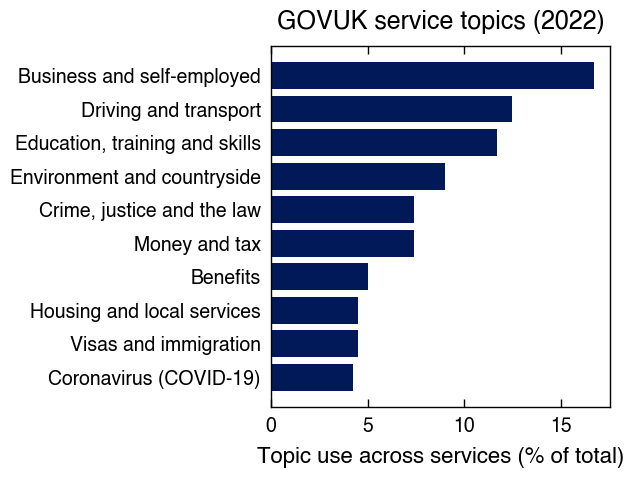

In [43]:
# get percentage
topics_df['perc'] = (topics_df['freq'] / topics_df['freq'].sum()) * 100
 
# creating the bar plot
plt.rcParams["font.family"] = "Helvetica"


fig = plt.figure()
plt.barh(topics_df.iloc[:10, :].topic, topics_df.iloc[:10, :].perc, color='#011959')
plt.gca().invert_yaxis()
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False) 

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False,         # ticks along the top edge are off
    bottom=False,         # ticks along the top edge are off
    labelright=False)

plt.title('GOVUK service topics (2022)', fontsize=9)
plt.xlabel('Topic use across services (% of total)', fontsize=8)
plt.ylabel('', fontsize=8)

plt.tight_layout()
plt.savefig("./src/visualisation/fig1-topics.pdf");

In [44]:
orgs = services2022['organisation'].value_counts()

orgs_df = pd.DataFrame({'org': orgs.index, 'freq': orgs.values})

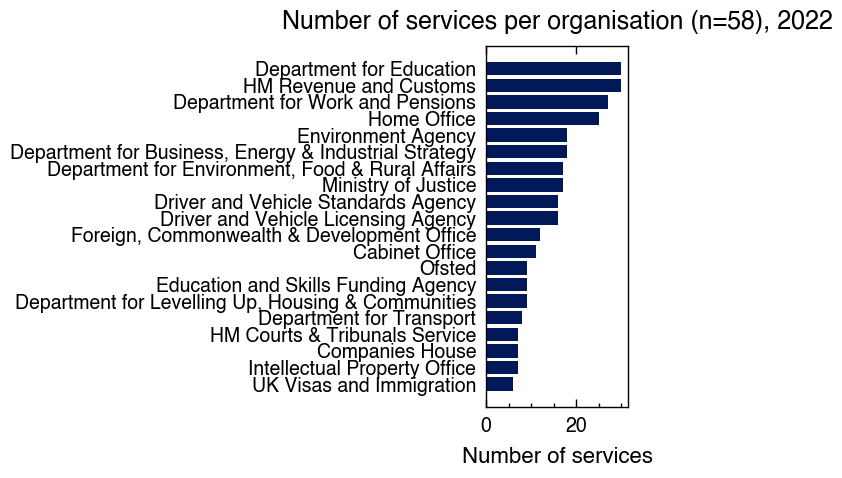

In [45]:

# creating the bar plot
plt.rcParams["font.family"] = "Helvetica"


fig = plt.figure()
plt.barh(orgs_df.iloc[:20, :].org, orgs_df.iloc[:20, :].freq, color='#011959')
plt.gca().invert_yaxis()
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelright=False) 

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    top=False,         # ticks along the top edge are off
    bottom=True,         # ticks along the top edge are off
    labelright=False)

plt.title('Number of services per organisation (n=58), 2022', fontsize=9)
plt.xlabel('Number of services', fontsize=8)
plt.ylabel('', fontsize=8)

plt.tight_layout()
# plt.savefig("./src/visualisation/fig1-topics.pdf");


## Organisation headcount

In [69]:
import numpy as np

headcount_df = pd.read_csv('./data/processed/202307-organisation-headcount.csv')
headcount_df['Headcount'] = pd.to_numeric(headcount_df['Headcount'])

In [71]:
headcount_df.loc[headcount_df['Headcount'] > 0].describe()

Headcount
count    149.000000
mean    4281.711409
std    13414.782699
min        5.000000
25%       80.000000
50%      435.000000
75%     1810.000000
max    91875.000000

In [707]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def science_style_bar_chart(df, category_col):
    # Group the DataFrame by 'service_category' and count the occurrences of each category
    category_counts = df[category_col].value_counts()

    # Set up the Science journal-style plot
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(8, 6), dpi=300)

    # Define a custom color palette matching the Science journal's style
    custom_palette = sns.color_palette("colorblind")

    # Create the bar chart
    ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=custom_palette)

    # Add counts on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, f"{int(height)}", ha="center")

    # Customize the plot
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(category_col, fontsize=14)
    plt.ylabel("Count", fontsize=14)

    # Add the specified title with the count of rows in the DataFrame
    plt.title(f"Service Group Count (n={len(df)})", fontsize=16)

    # Show the plot
    plt.tight_layout()

    # Remove the top and right spines
    sns.despine()

    # Save the plot with high resolution (adjust the filename and path as needed)
    plt.savefig("science_style_bar_chart.png", dpi=300)
    plt.show()

# Example usage:
# Assuming you have a DataFrame called 'df' with the column 'service_category'
# Call the function like this:
science_style_bar_chart(df, 'service_category')

KeyError: 'service_category'

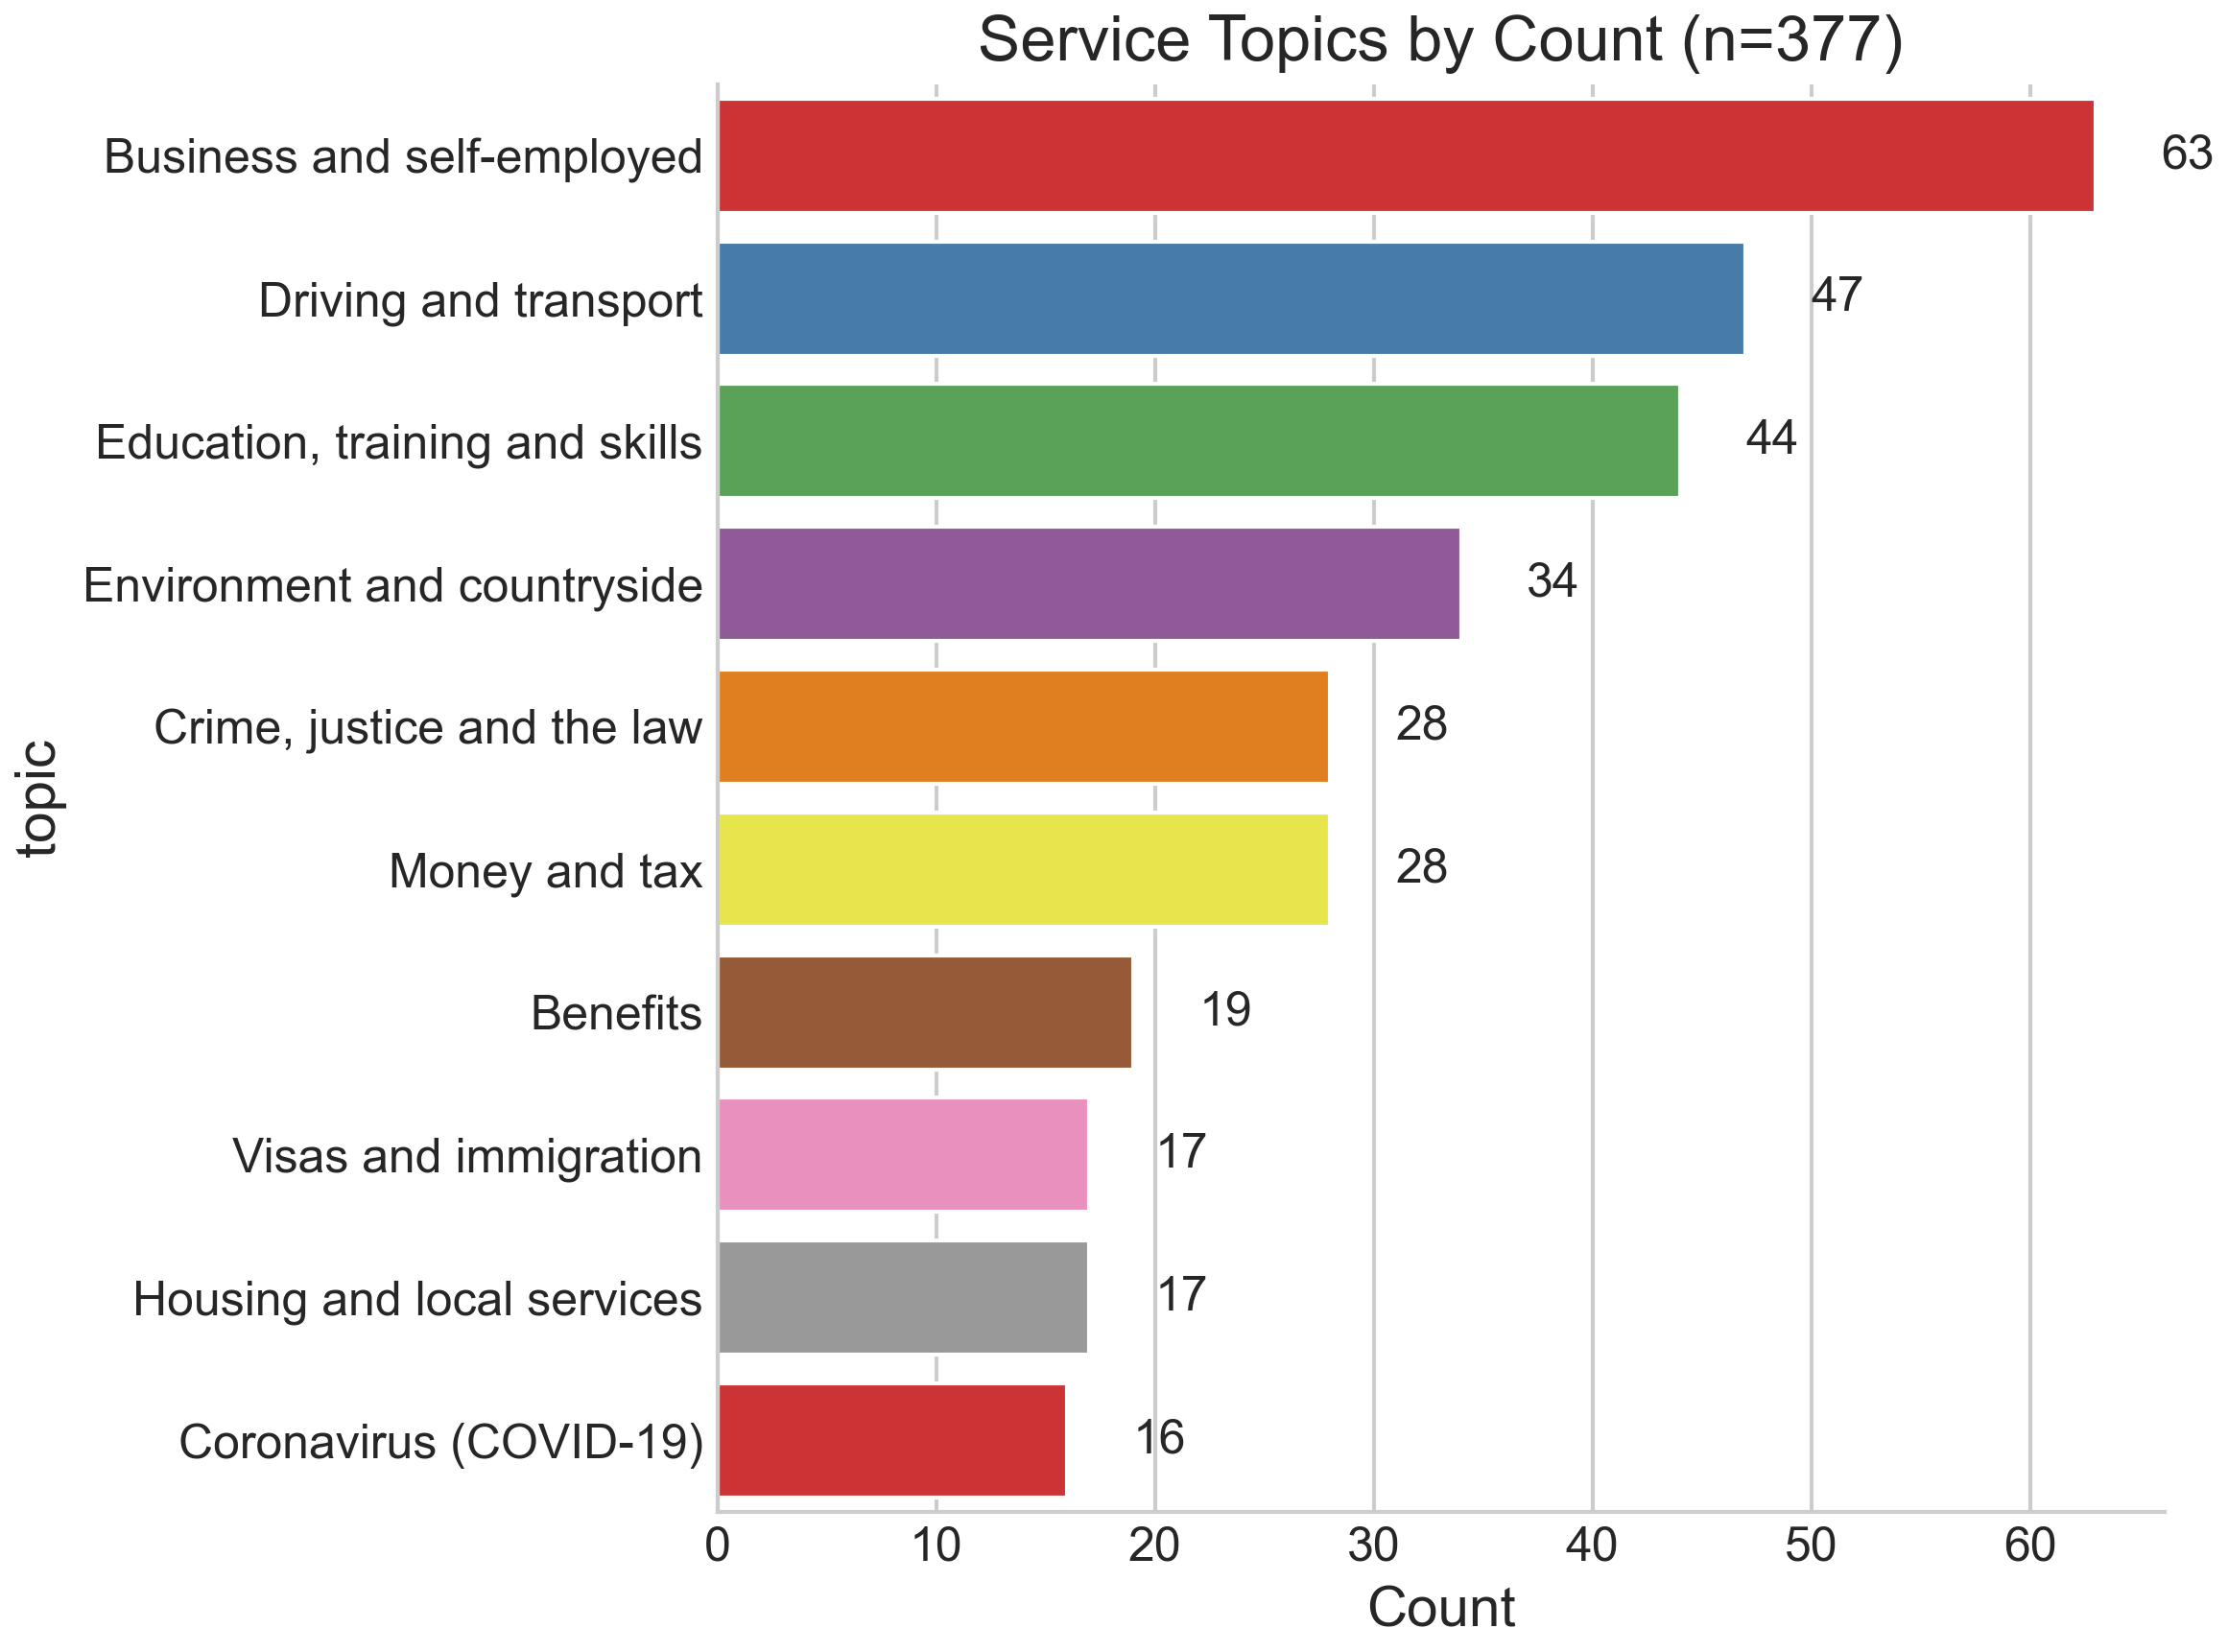

In [708]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def science_style_bar_chart(df, category_col):
    # Group the DataFrame by 'topic' and count the occurrences of each category
    category_counts = df[category_col].value_counts()

    # Select the top 10 categories based on count
    top_10_categories = category_counts.head(10)

    # Set Helvetica as the font
    plt.rcParams['font.family'] = 'Helvetica'

    # Set up the Science journal-style plot
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(8, 6), dpi=300)

    # Define a custom color palette matching the Science journal's style
    custom_palette = sns.color_palette("Set1", n_colors=len(top_10_categories))

    # Create the bar chart with y and x axes swapped
    ax = sns.barplot(x=top_10_categories.values, y=top_10_categories.index, palette=custom_palette)

    # Add counts on top of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 3, p.get_y() + p.get_height() / 2., f"{int(width)}", va="center")

    # Customize the plot
    plt.xticks(fontsize=12)
    plt.yticks(rotation=0, ha='right', fontsize=12)
    plt.xlabel("Count", fontsize=14)
    plt.ylabel(category_col, fontsize=14)

    # Add the specified title with the count of rows in the DataFrame
    plt.title(f"Service Topics by Count (n={len(df)})", fontsize=16)

    # Remove the top and right spines
    sns.despine()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a DataFrame called 'df' with the column 'topic'
# Call the function like this:
science_style_bar_chart(descriptive_df, 'topic')

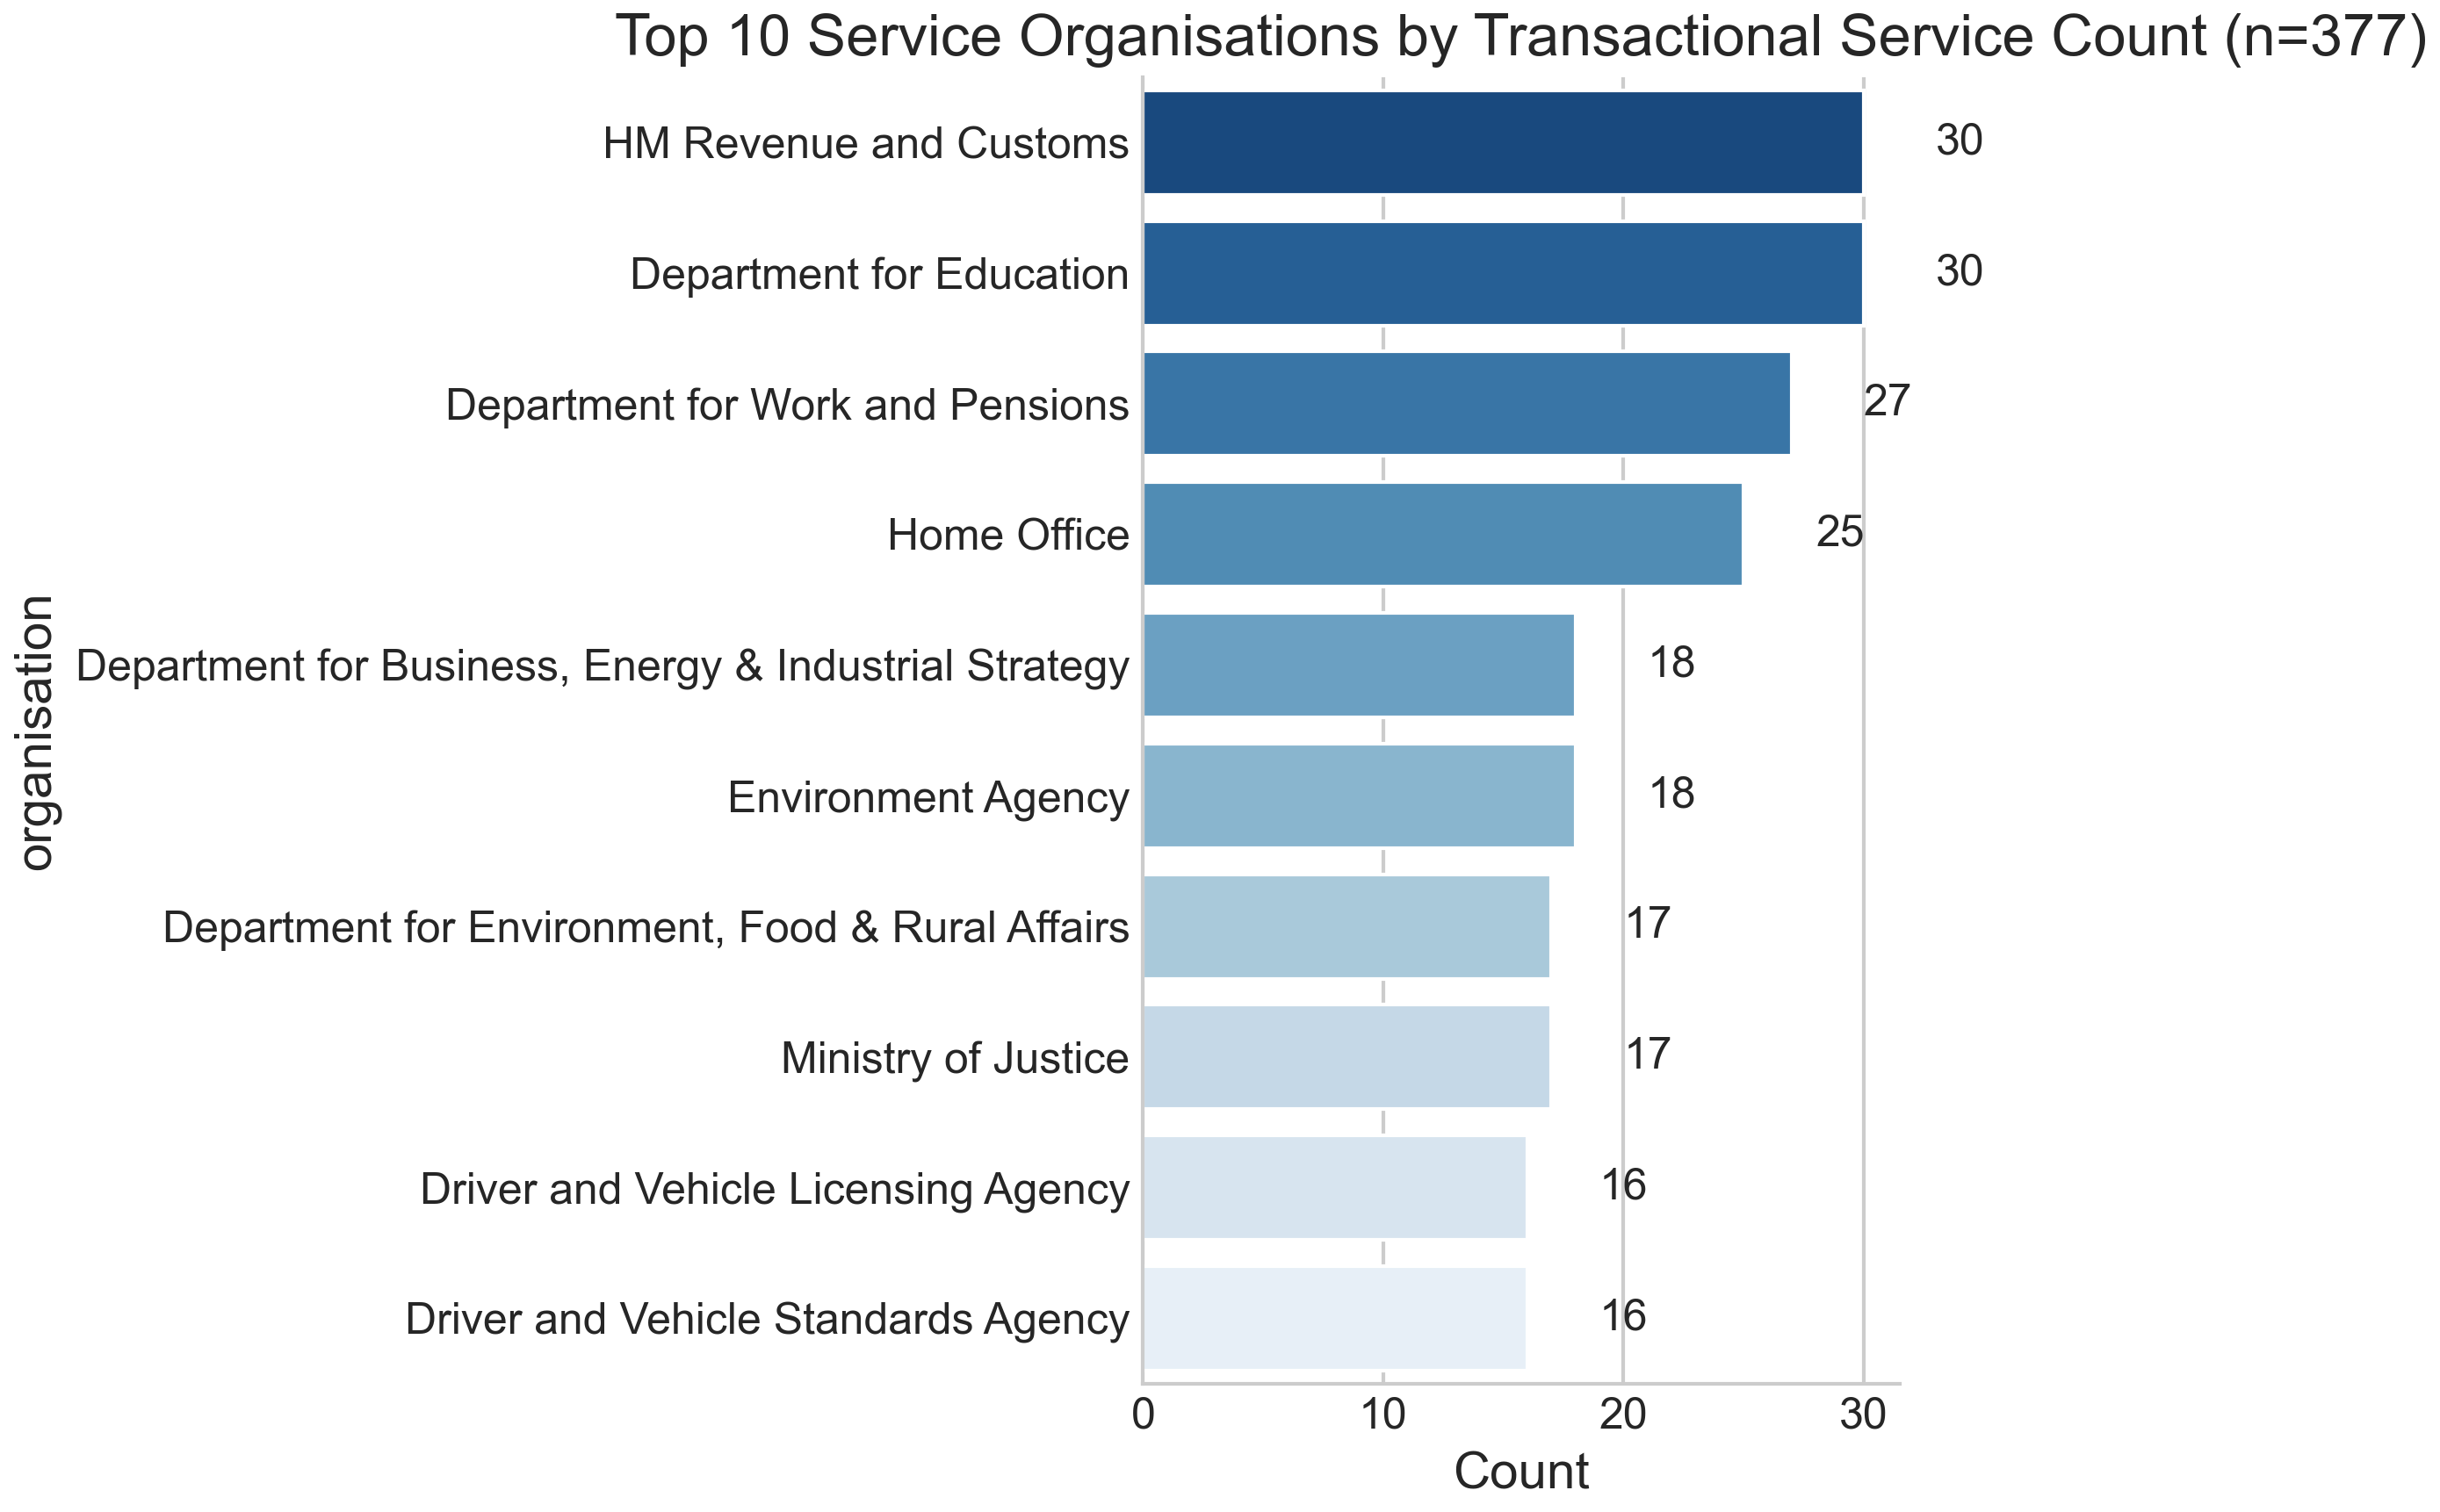

In [709]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def science_style_bar_chart(df, category_col):
    # Group the DataFrame by 'topic' and count the occurrences of each category
    category_counts = df[category_col].value_counts()

    # Select the top 10 categories based on count
    top_10_categories = category_counts.head(10)

    # Set Helvetica as the font
    plt.rcParams['font.family'] = 'Helvetica'

    # Set up the Science journal-style plot
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(8, 6), dpi=300)

    # Define a custom color palette matching the Science journal's style
    custom_palette = sns.color_palette("Blues_r", n_colors=len(top_10_categories))

    # Create the bar chart with y and x axes swapped
    ax = sns.barplot(x=top_10_categories.values, y=top_10_categories.index, palette=custom_palette)

    # Add counts on top of each bar
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 3, p.get_y() + p.get_height() / 2., f"{int(width)}", va="center")

    # Customize the plot
    plt.xticks(fontsize=12)
    plt.yticks(rotation=0, ha='right', fontsize=12)
    plt.xlabel("Count", fontsize=14)
    plt.ylabel(category_col, fontsize=14)

    # Add the specified title with the count of rows in the DataFrame
    plt.title(f"Top 10 Service Organisations by Transactional Service Count (n={len(df)})", fontsize=16)

    # Remove the top and right spines
    sns.despine()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
science_style_bar_chart(descriptive_df, 'organisation')

## Add the below to a script

## Descriptive statistics

In [710]:
def return_top_items_dataframe(df, column_name, num_top_items=10):
    # Combine all items from the column into a single list
    all_items = [item for sublist in df[column_name] for item in sublist]
    
    # Create a pandas Series from the list of items and count occurrences
    item_counts = pd.Series(all_items).value_counts()
    
    # Create a DataFrame with top items and their counts
    top_items_df = pd.DataFrame({'Top Items': item_counts.index[:num_top_items],
                                 'Count': item_counts.values[:num_top_items]})
    
    # Display the top items DataFrame
    return top_items_df


def display_dataframe_full(df):
    # Set display options to show full content of cells
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)
    
    # Display the DataFrame
    print(df)
    
    # Reset display options to their default values
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.expand_frame_repr')


def science_style_bar_chart(df, x='Top Items', y='Count', xlabel='Task content category', 
                           ylabel="Count", title=f"Service Task Category Counts", group_by=None):
    # Set up the Science journal-style plot
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(8, 6), dpi=300)

    # Define a custom color palette matching the Science journal's style
    custom_palette = sns.color_palette("tab10")

    # Create the bar chart
    if group_by:
        ax = sns.barplot(x=df[x], y=df[y], hue=df[group_by], palette=custom_palette)
    else:
        ax = sns.barplot(x=df[x], y=df[y], palette=custom_palette)

    # Add counts on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, f"{int(height)}", ha="center")

    # Customize the plot
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add the specified title with the count of rows in the DataFrame
    plt.title(title, fontsize=16)

    # Show the plot
    plt.tight_layout()

    # Remove the top and right spines
    sns.despine()

    # Save the plot with high resolution (adjust the filename and path as needed)
    plt.savefig("science_style_bar_chart.png", dpi=300)
    plt.show()

##### tasks per service

In [711]:
analysis_df['task_count'] = analysis_df[['NRA', 'RM', 'NRM', 'RC', 'NRI']].sum(axis=1)
analysis_df[['task_count']].describe()

task_count
count  201.000000
mean     7.089552
std      3.515955
min      1.000000
25%      5.000000
50%      7.000000
75%      8.000000
max     23.000000

##### task content categories

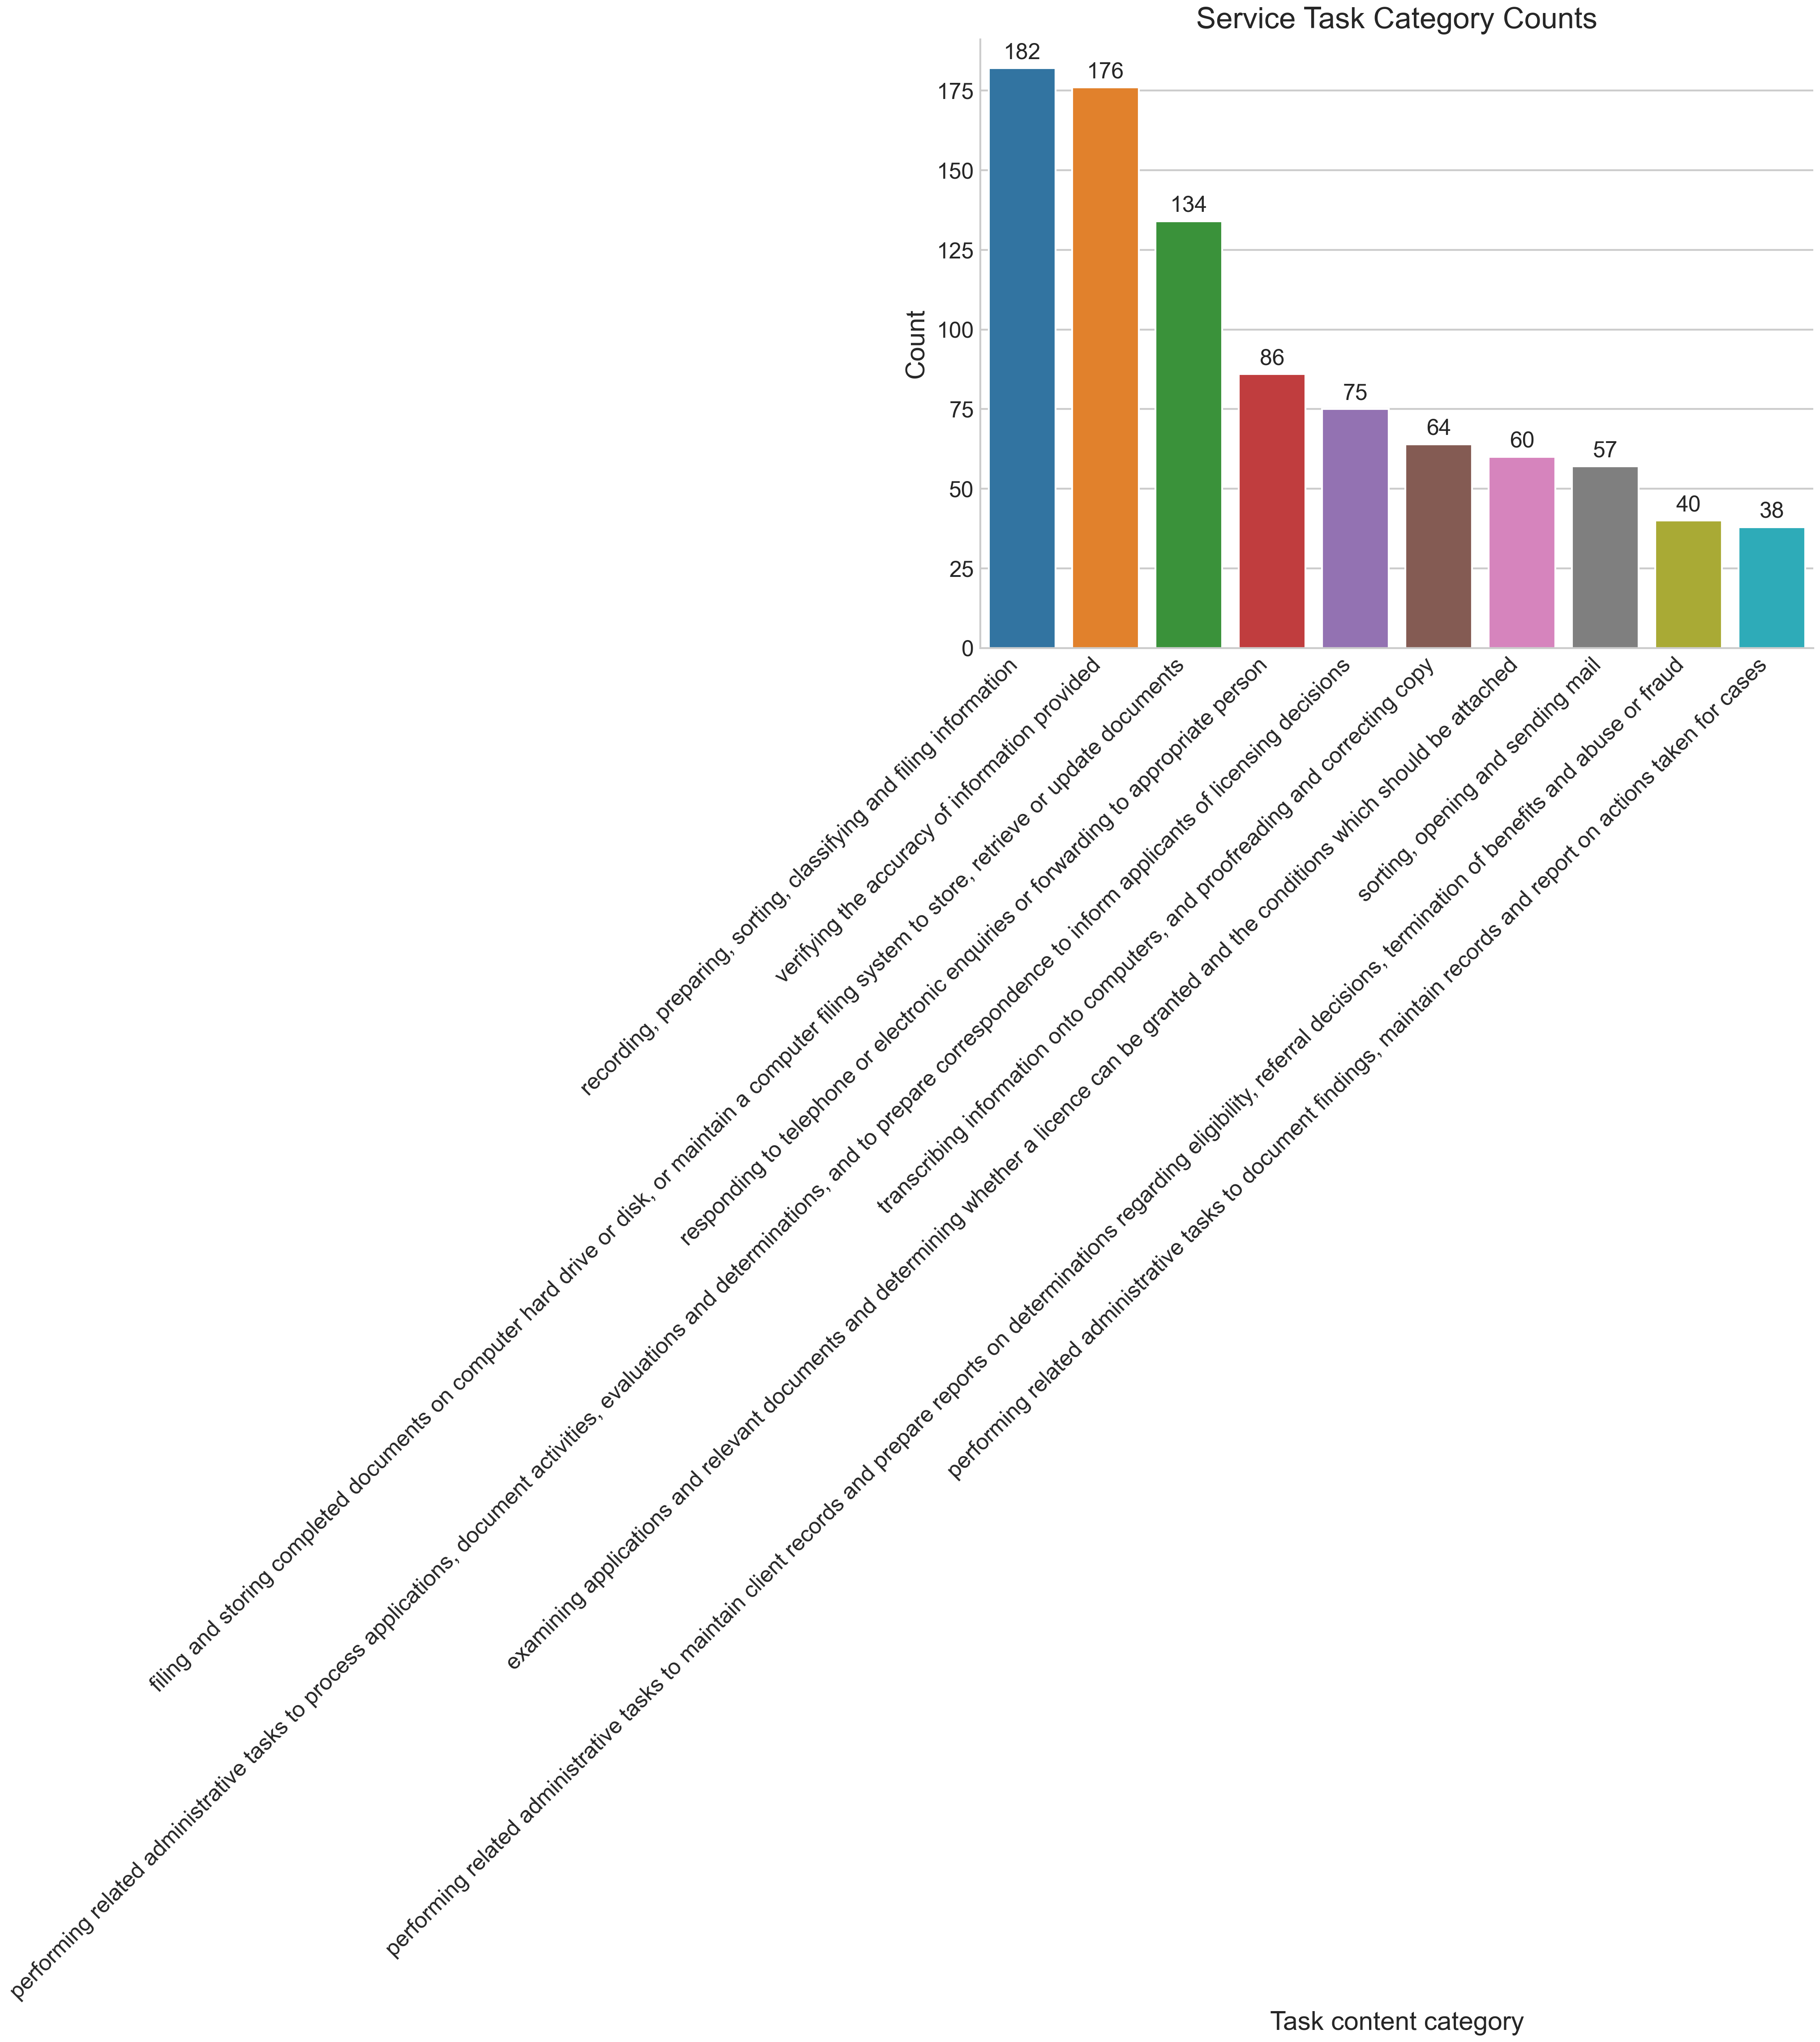

In [712]:
science_style_bar_chart(
    return_top_items_dataframe(
        analysis_df, 'service_tasks', num_top_items=10
    ), x='Top Items', y='Count'
)

### Analyse task group categories

In [ ]:
# Define the replacement dictionary
replacement_dict = {
    'RC': 'Routine cognitive',
    'NRA': 'Non-routine analytic',
    'RM': 'Routine manual',
    'NRI': 'Non-routine interactive'
}

# Replace the values in the 'task_group_category' column using the dictionary
analysis_df['task_group_category'] = analysis_df['task_group_category'].apply(lambda x: [replacement_dict[val] for val in x])

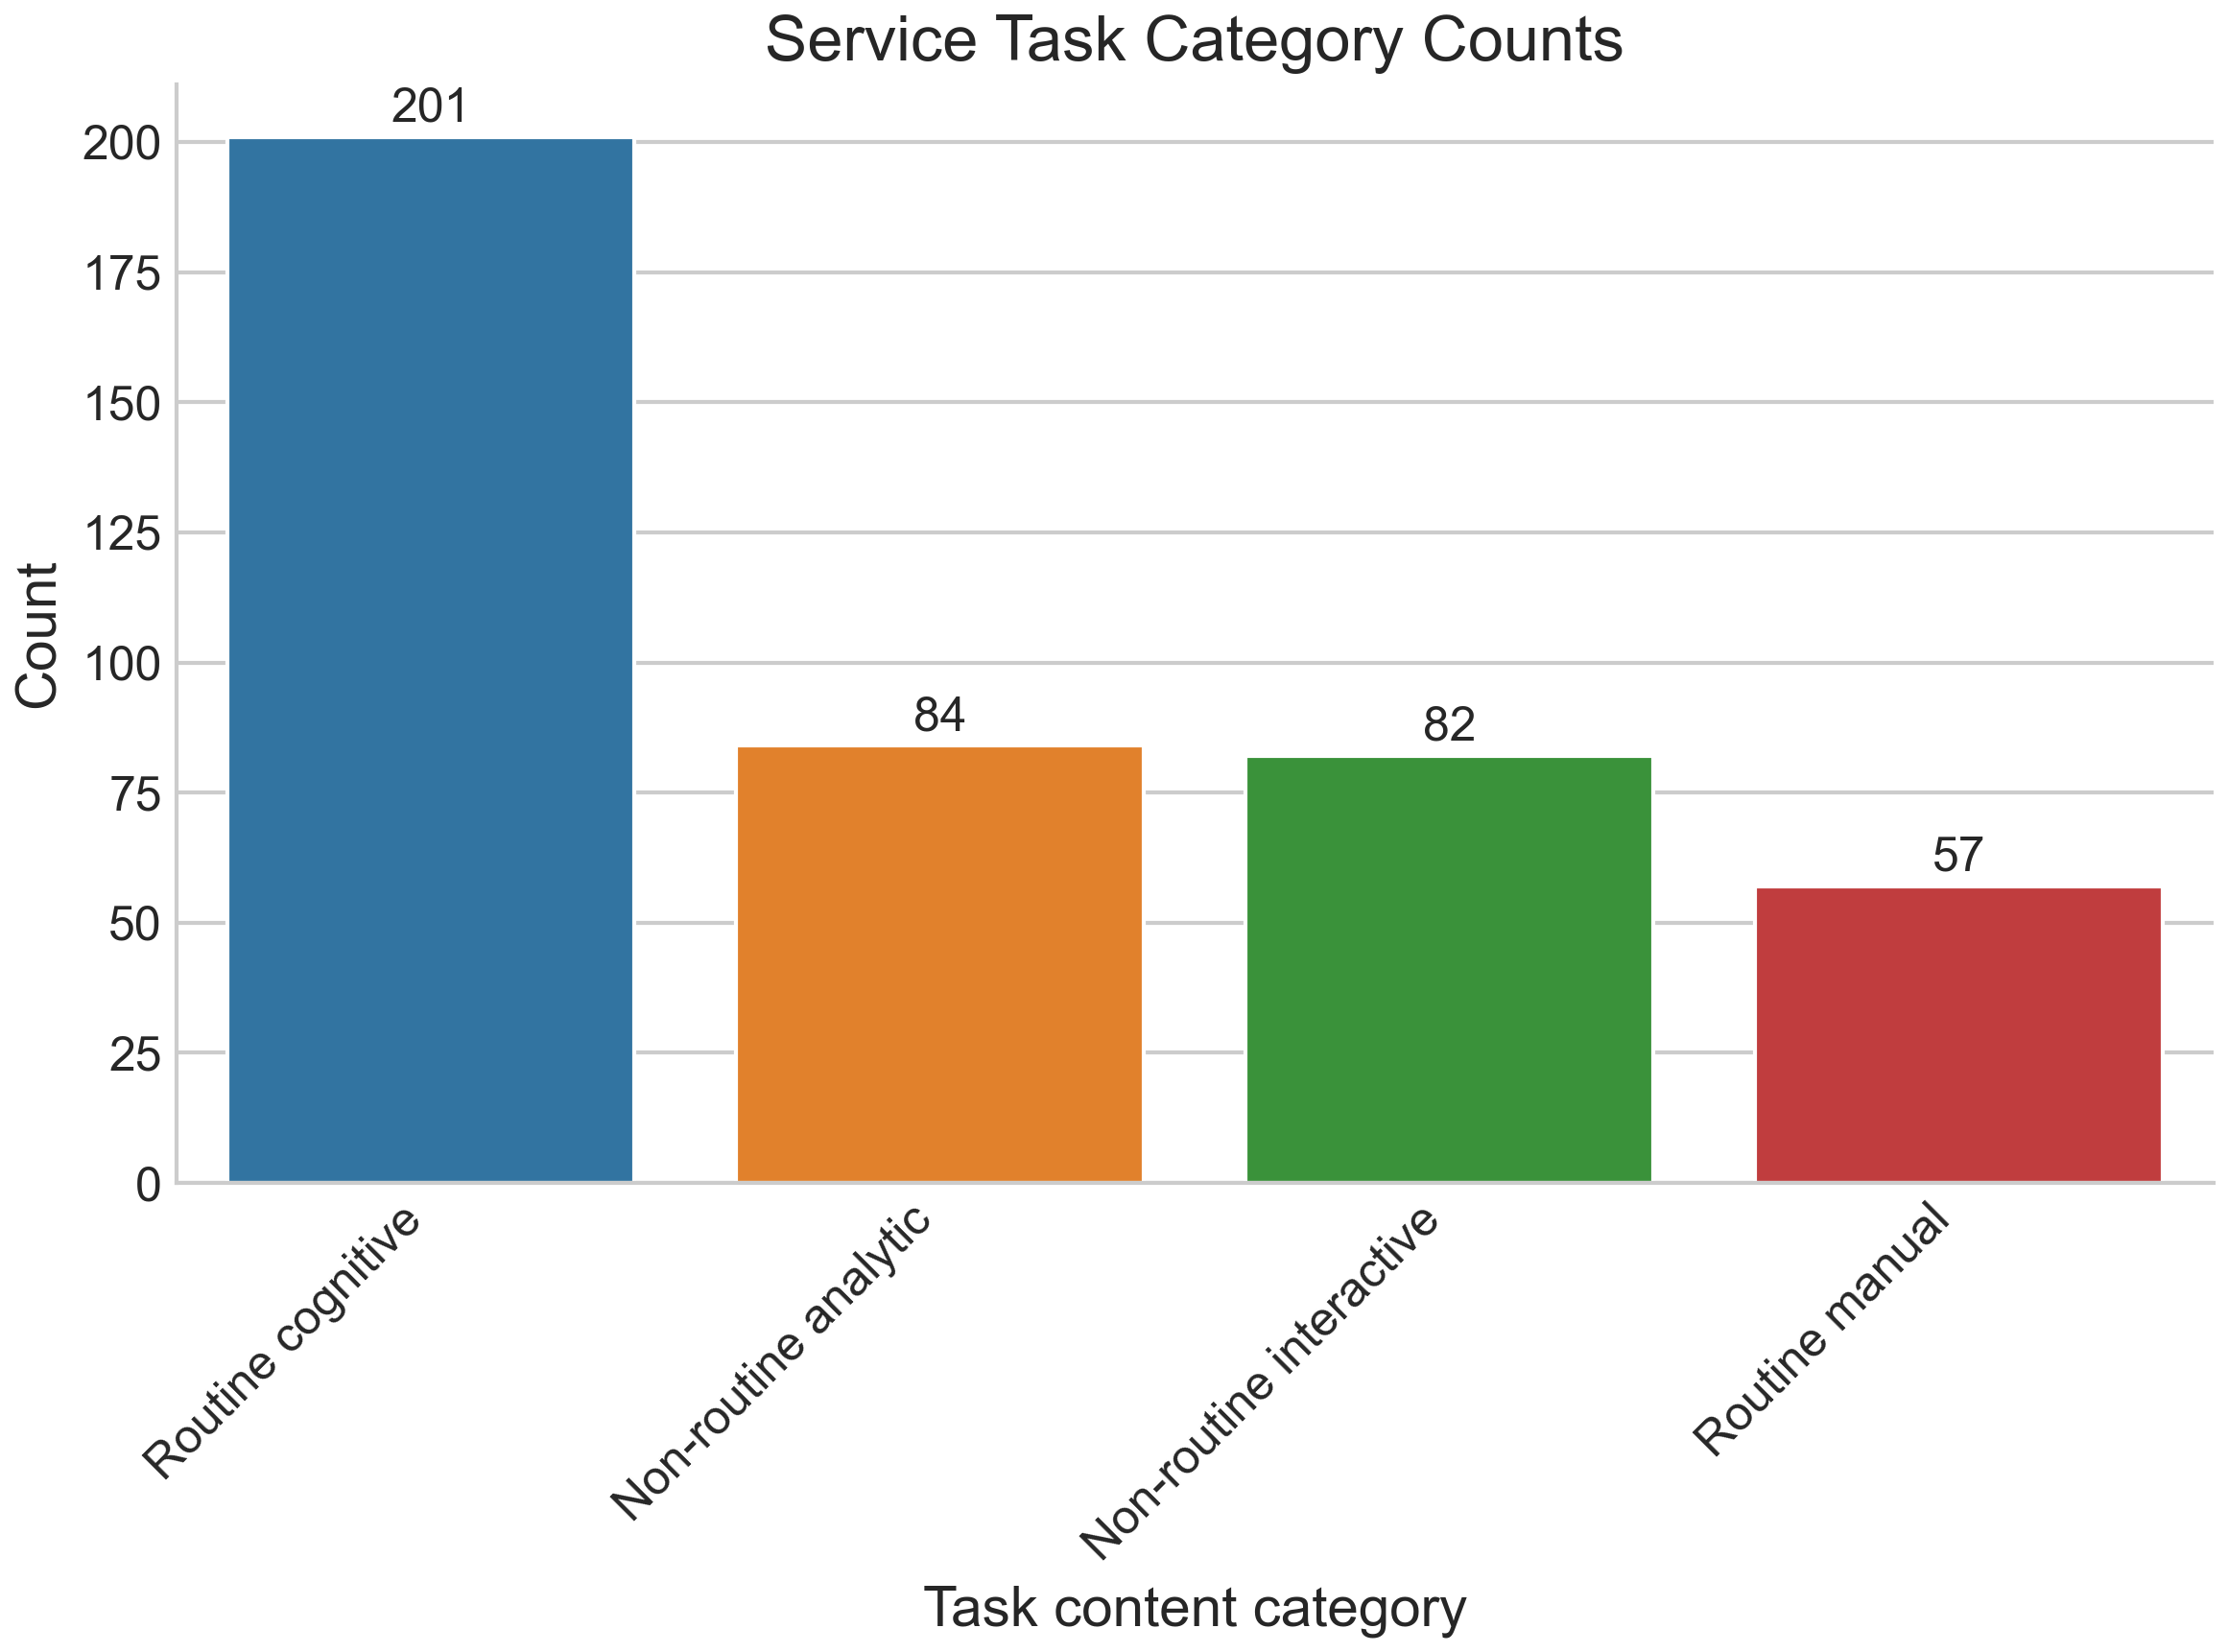

In [715]:
science_style_bar_chart(
    return_top_items_dataframe(analysis_df, 'task_group_category', num_top_items=10))

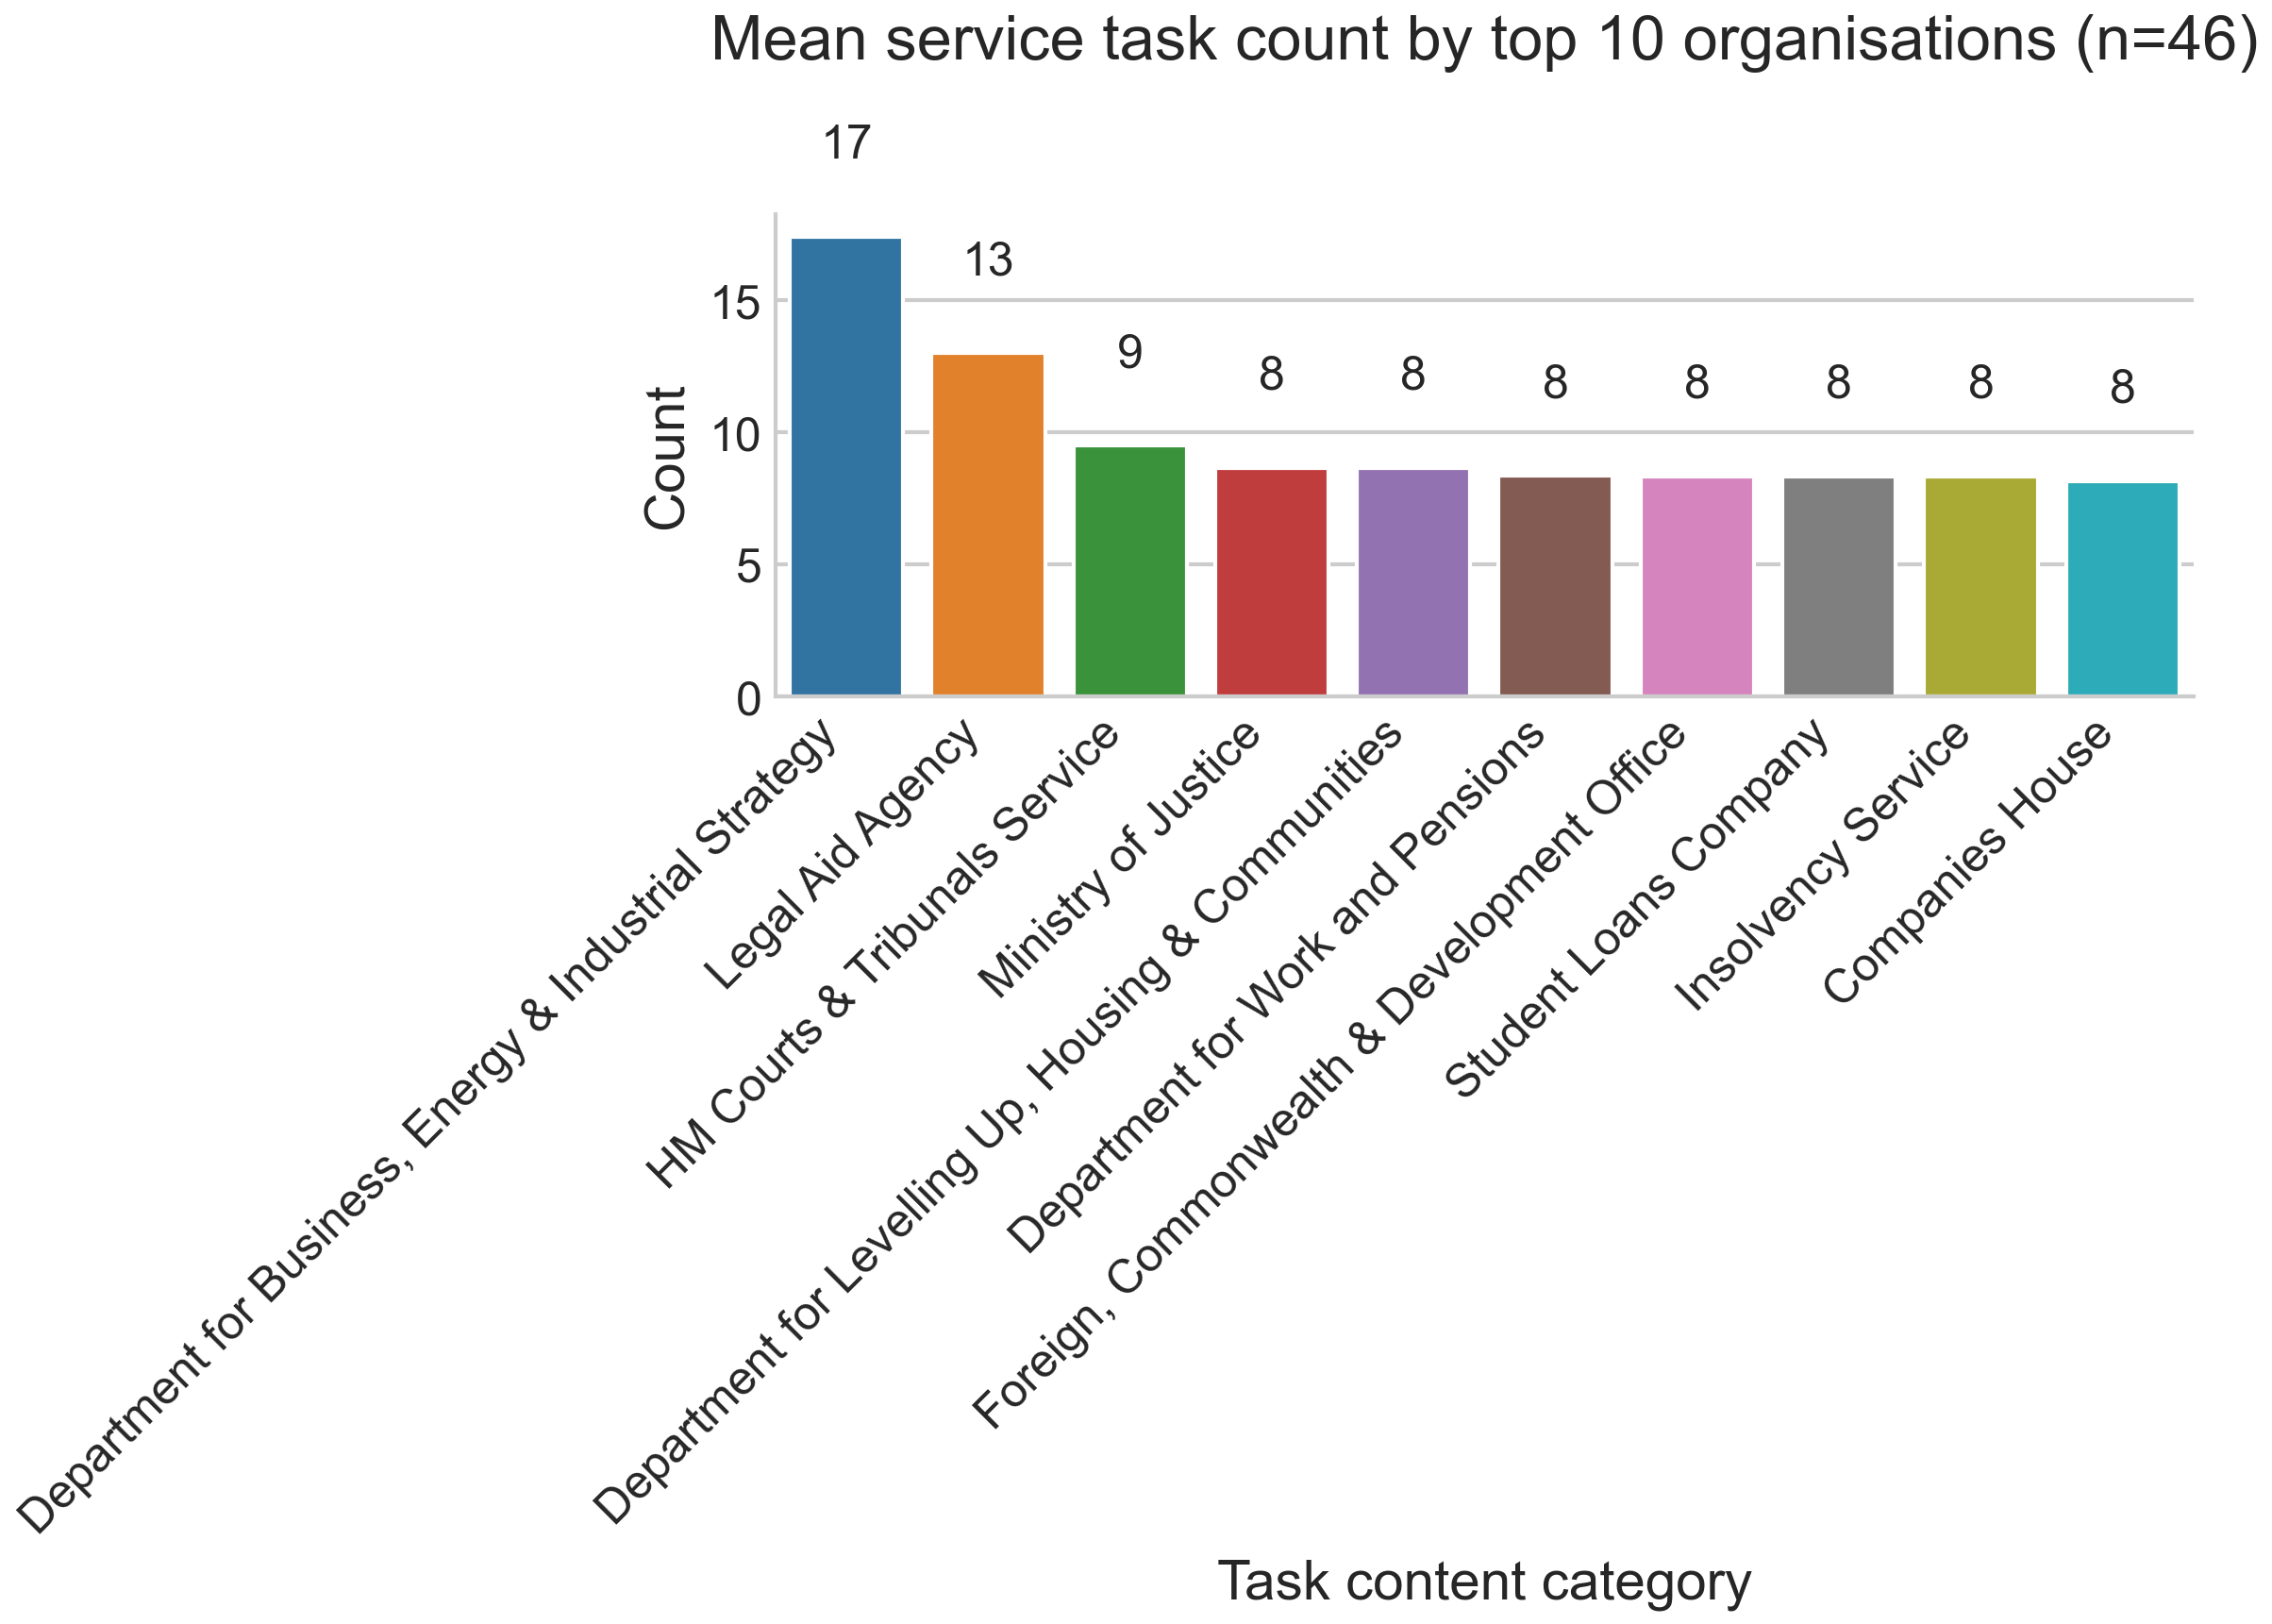

In [716]:
# Group by 'organisation' and count the sum of rows for 'service'
grouped = pd.DataFrame({'organisation': analysis_df.groupby('organisation')['task_count'].mean().index,
              'Count': analysis_df.groupby('organisation')['task_count'].mean().values})

science_style_bar_chart(
    grouped.sort_values(by='Count', ascending=False).iloc[:10, :],
    x='organisation', title='Mean service task count by top 10 organisations (n=46)\n\n'
)

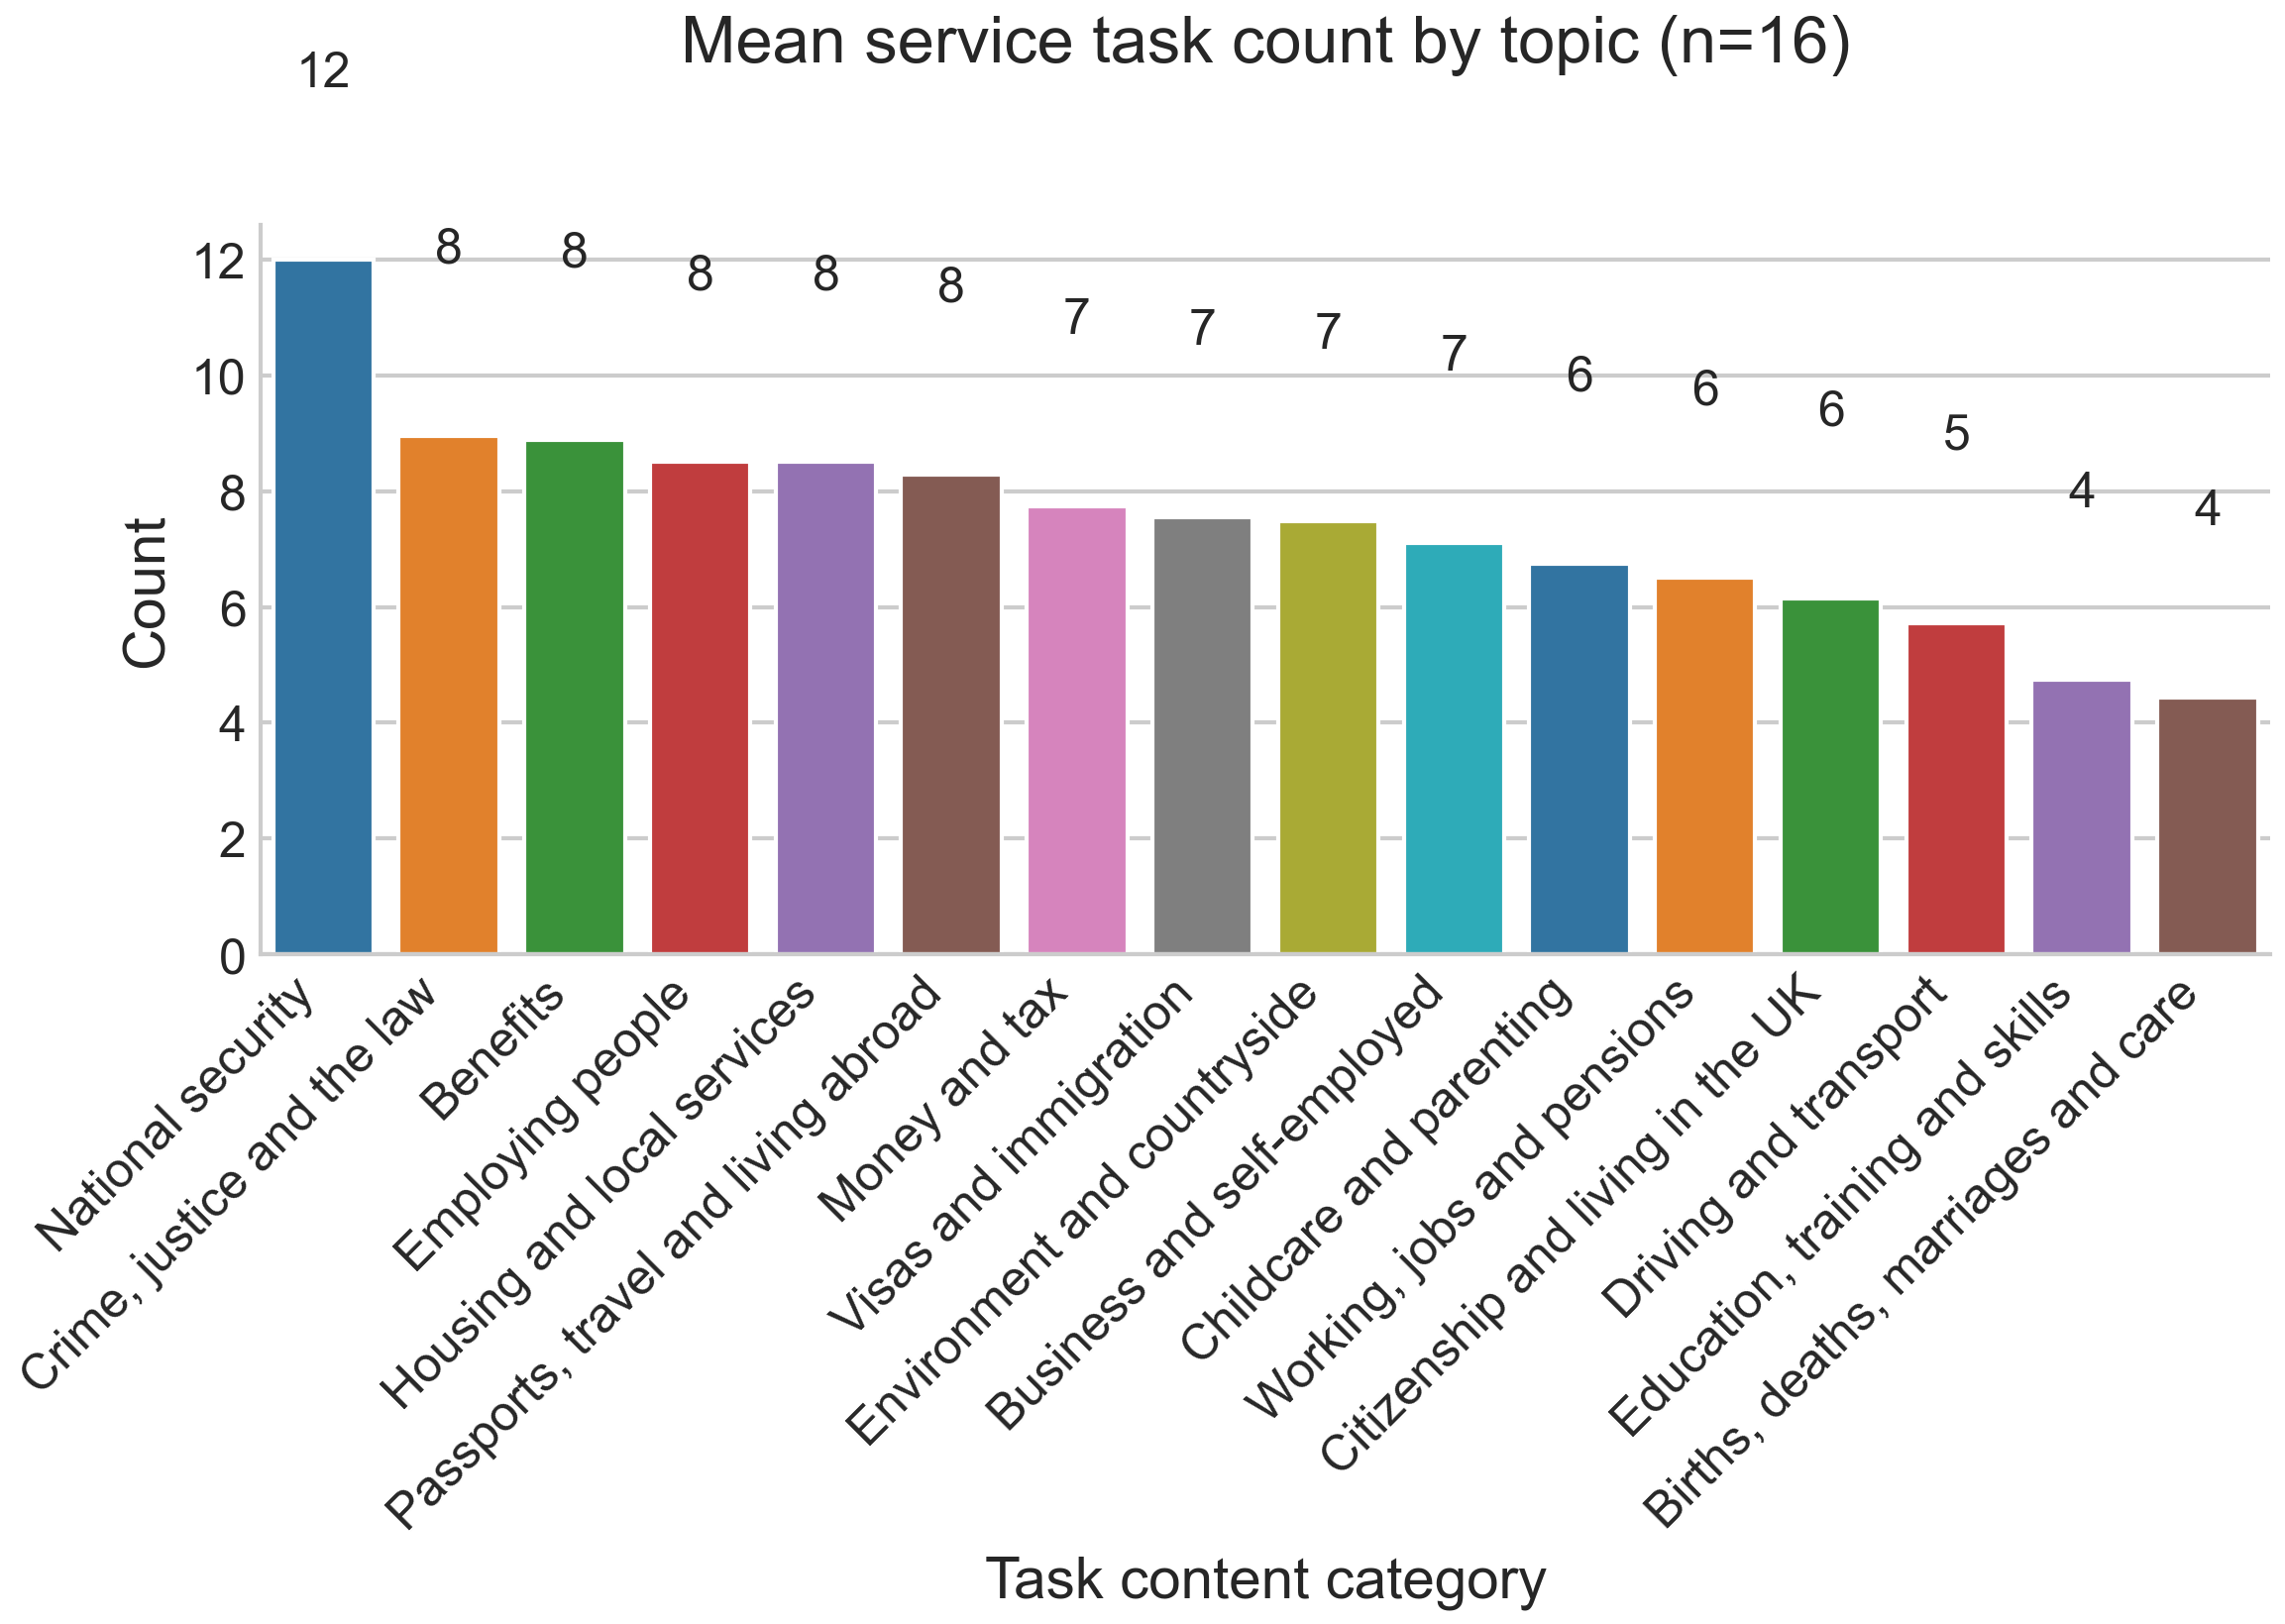

In [717]:
# Group by 'topic' and count the sum of rows for 'service'
grouped = pd.DataFrame({'topic': analysis_df.groupby('topic')['task_count'].mean().index,
              'Count': analysis_df.groupby('topic')['task_count'].mean().values})

science_style_bar_chart(
    grouped.sort_values(by='Count', ascending=False).iloc[:, :],
        x='topic', title='Mean service task count by topic (n=16)\n\n'
)

# Automatability of Service Tasks

In [718]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
    
def plot_service_distribution(dataframe, metric='RTI_NRI', label='Non-routine interactive', xticks=True):
    # Set the style to match Nature/Science
    style.use('seaborn-whitegrid')
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'Helvetica'
    plt.rcParams['font.size'] = 12  # Set font size

    # Sort the data
    sorted_data = dataframe.sort_values(by=metric)

    # Plotting
    plt.figure(figsize=(8, 6), dpi=300)
    ax = sns.barplot(data=sorted_data, x='service', y=metric, color='blue')

    plt.axhline(sorted_data[metric].mean(), color='red', linestyle='dashed', linewidth=2)
    plt.xlabel('')
    
    if metric == 'RTI_RC':
            plt.ylabel(metric[-2:] + ' score', fontsize=14)
    
    else:
        plt.ylabel(metric[-4:] + ' score', fontsize=14)
        
    plt.title(label, fontsize=16)
    ax.xaxis.set_tick_params(rotation=70)
    plt.xticks(fontsize=10)   

    if xticks == False:
        plt.xticks([])  

    plt.ylabel('Routine-task instensity score')
    
    plt.ylim(-.25,1)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()



### Descripitive stats

In [719]:
# Assuming you have the analysis_df DataFrame and the compute_RTI_scores function
# Call the function to compute and add RTI scores
analysis_df = compute_and_add_rti_scores(analysis_df, compute_RTI_scores)

### Priority services to flag in presenting ATS scores

In [720]:
len(analysis_df.loc[(analysis_df['priority'] == True) & (analysis_df['RTI'] >= 1)])

10

### Priority services that we ignored (labelled as fully automated or information-based):

In [721]:
all_services_df.loc[(
    all_services_df['excluded'] == True) & (all_services_df['priority'] == True
)].service

323    apply for new style jobseeker’s allowance
340               check if you can get legal aid
342              send money to someone in prison
348        view your driving licence information
350          find and compare schools in england
351                get information about schools
352                            get into teaching
355                     national careers service
357              check your long term flood risk
362                        foreign travel advice
Name: service, dtype: object

### Temporary graphics for CDDO

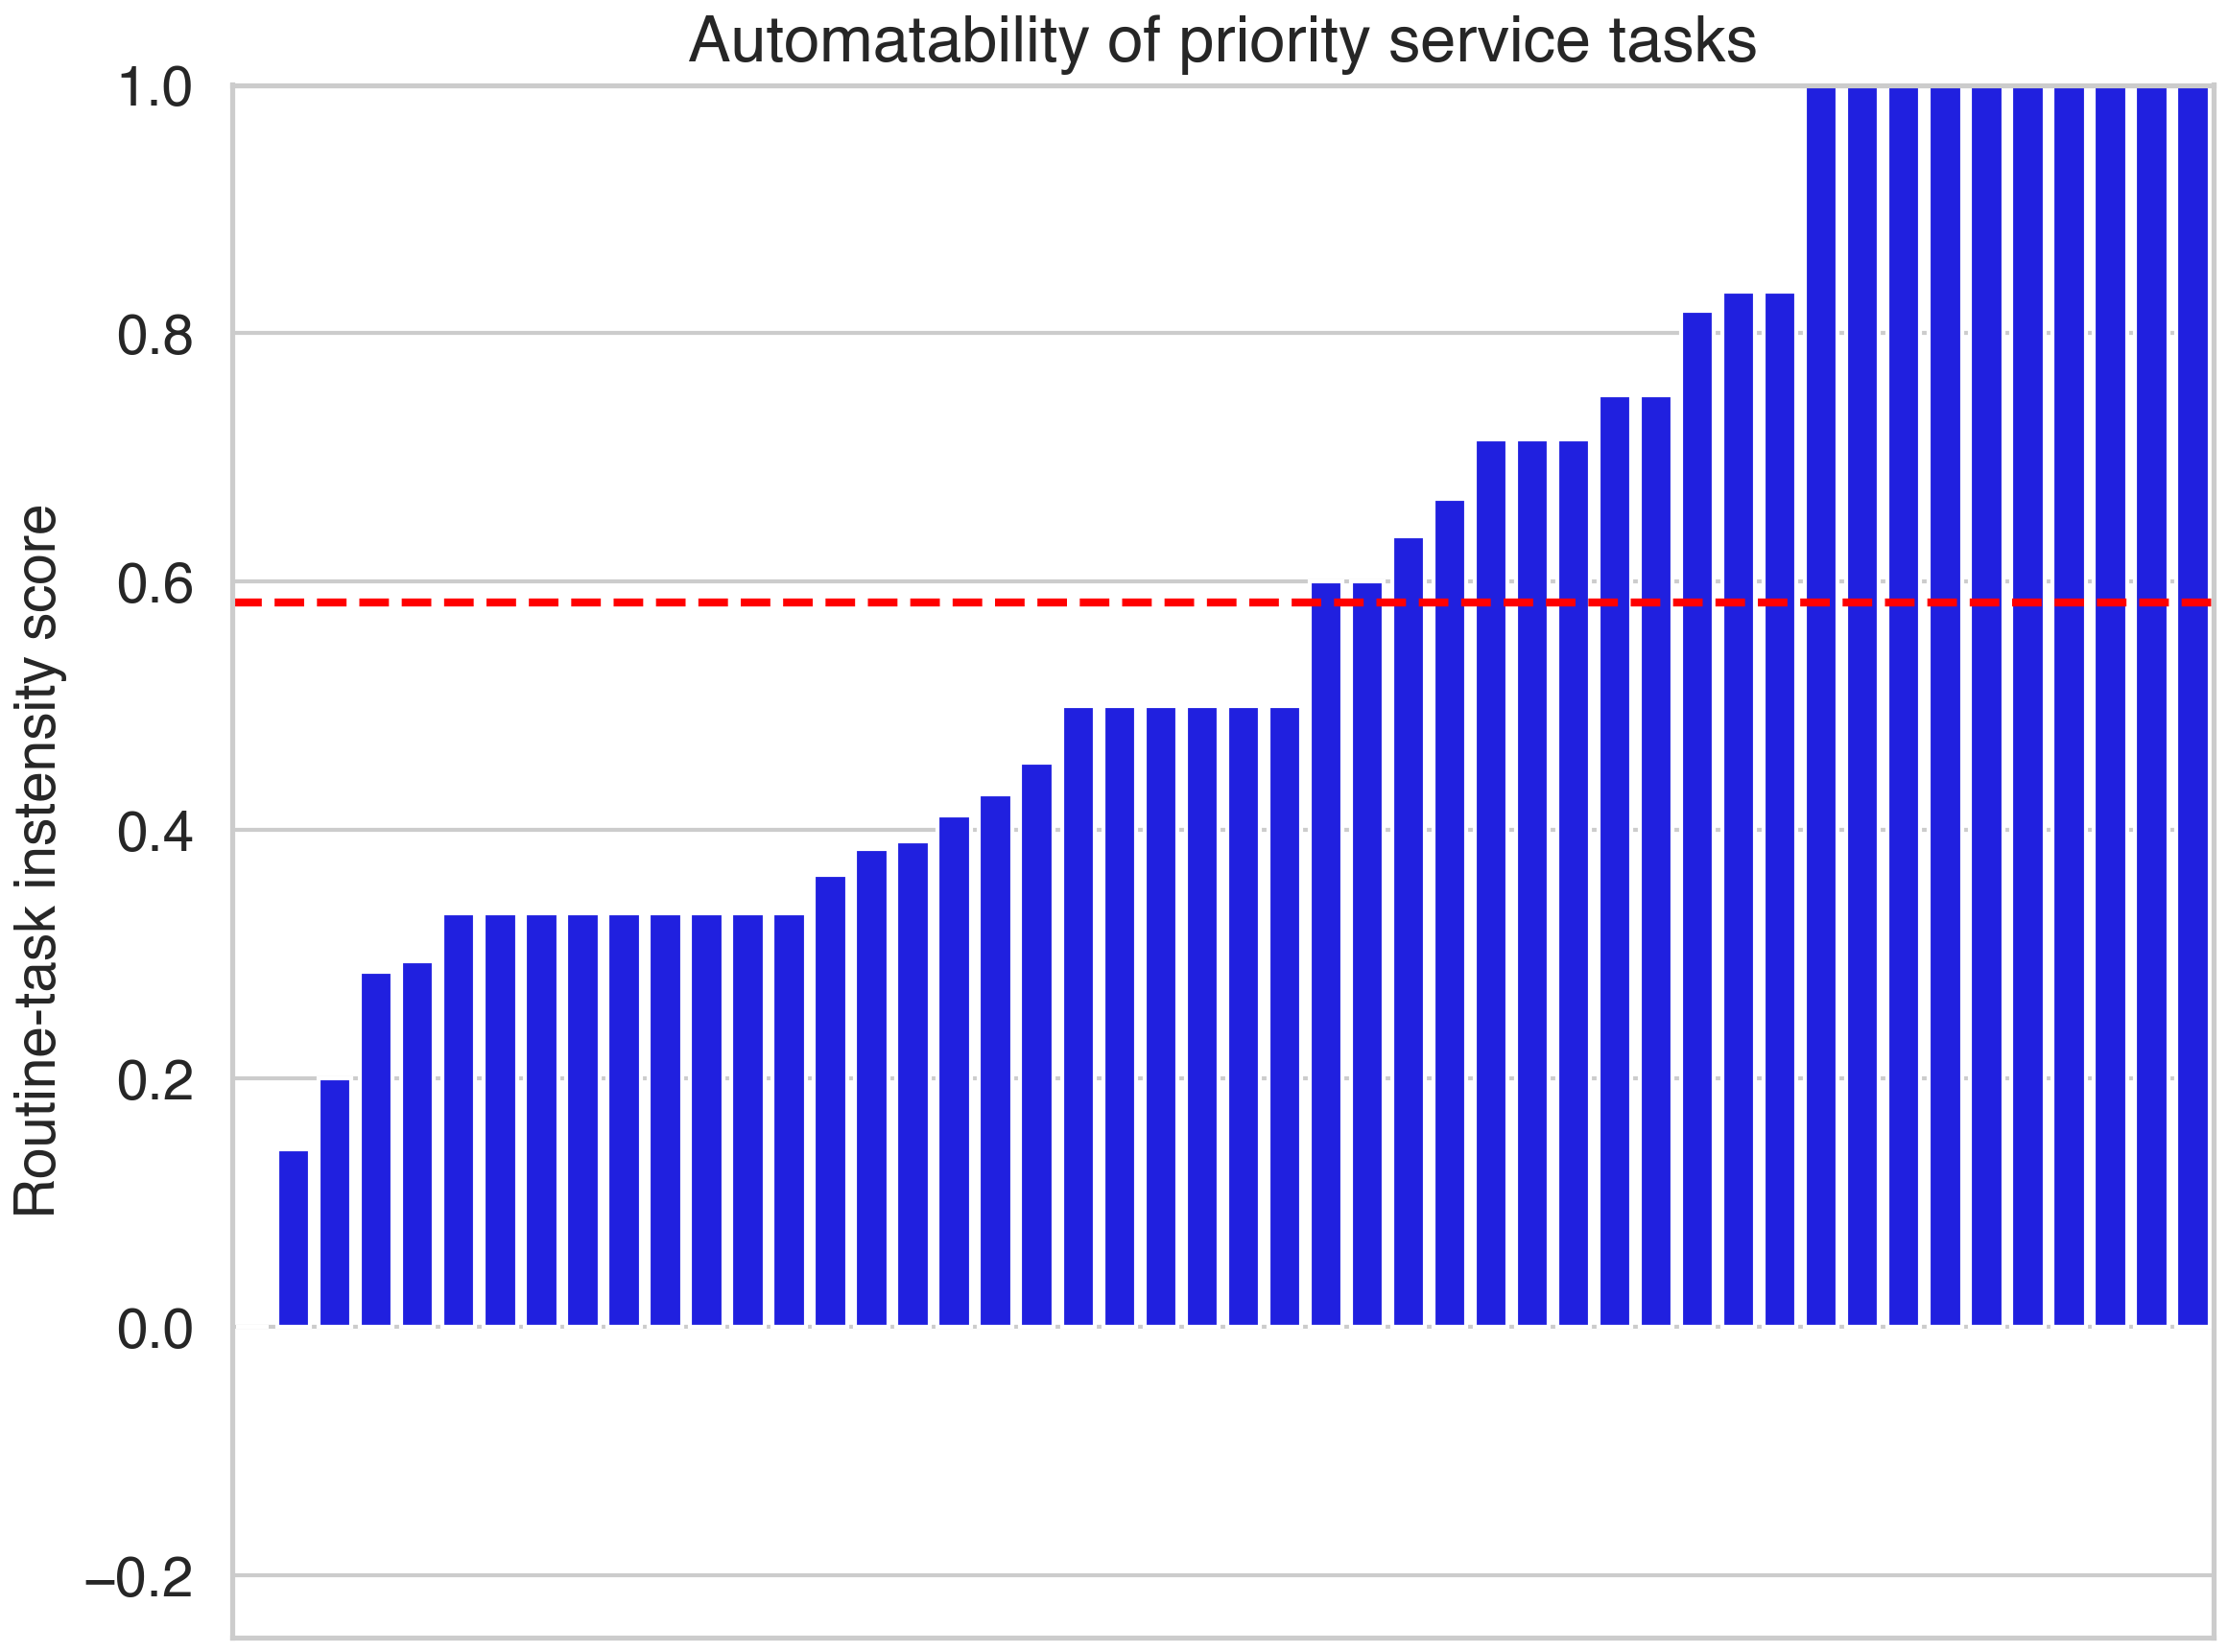

In [722]:
# Assuming 'x' is your DataFrame
plot_service_distribution(analysis_df.loc[analysis_df['priority'] == True], metric='RTI', label='Automatability of priority service tasks',
                         xticks=False)

In [723]:
len(analysis_df.loc[analysis_df['priority'] == True])

48

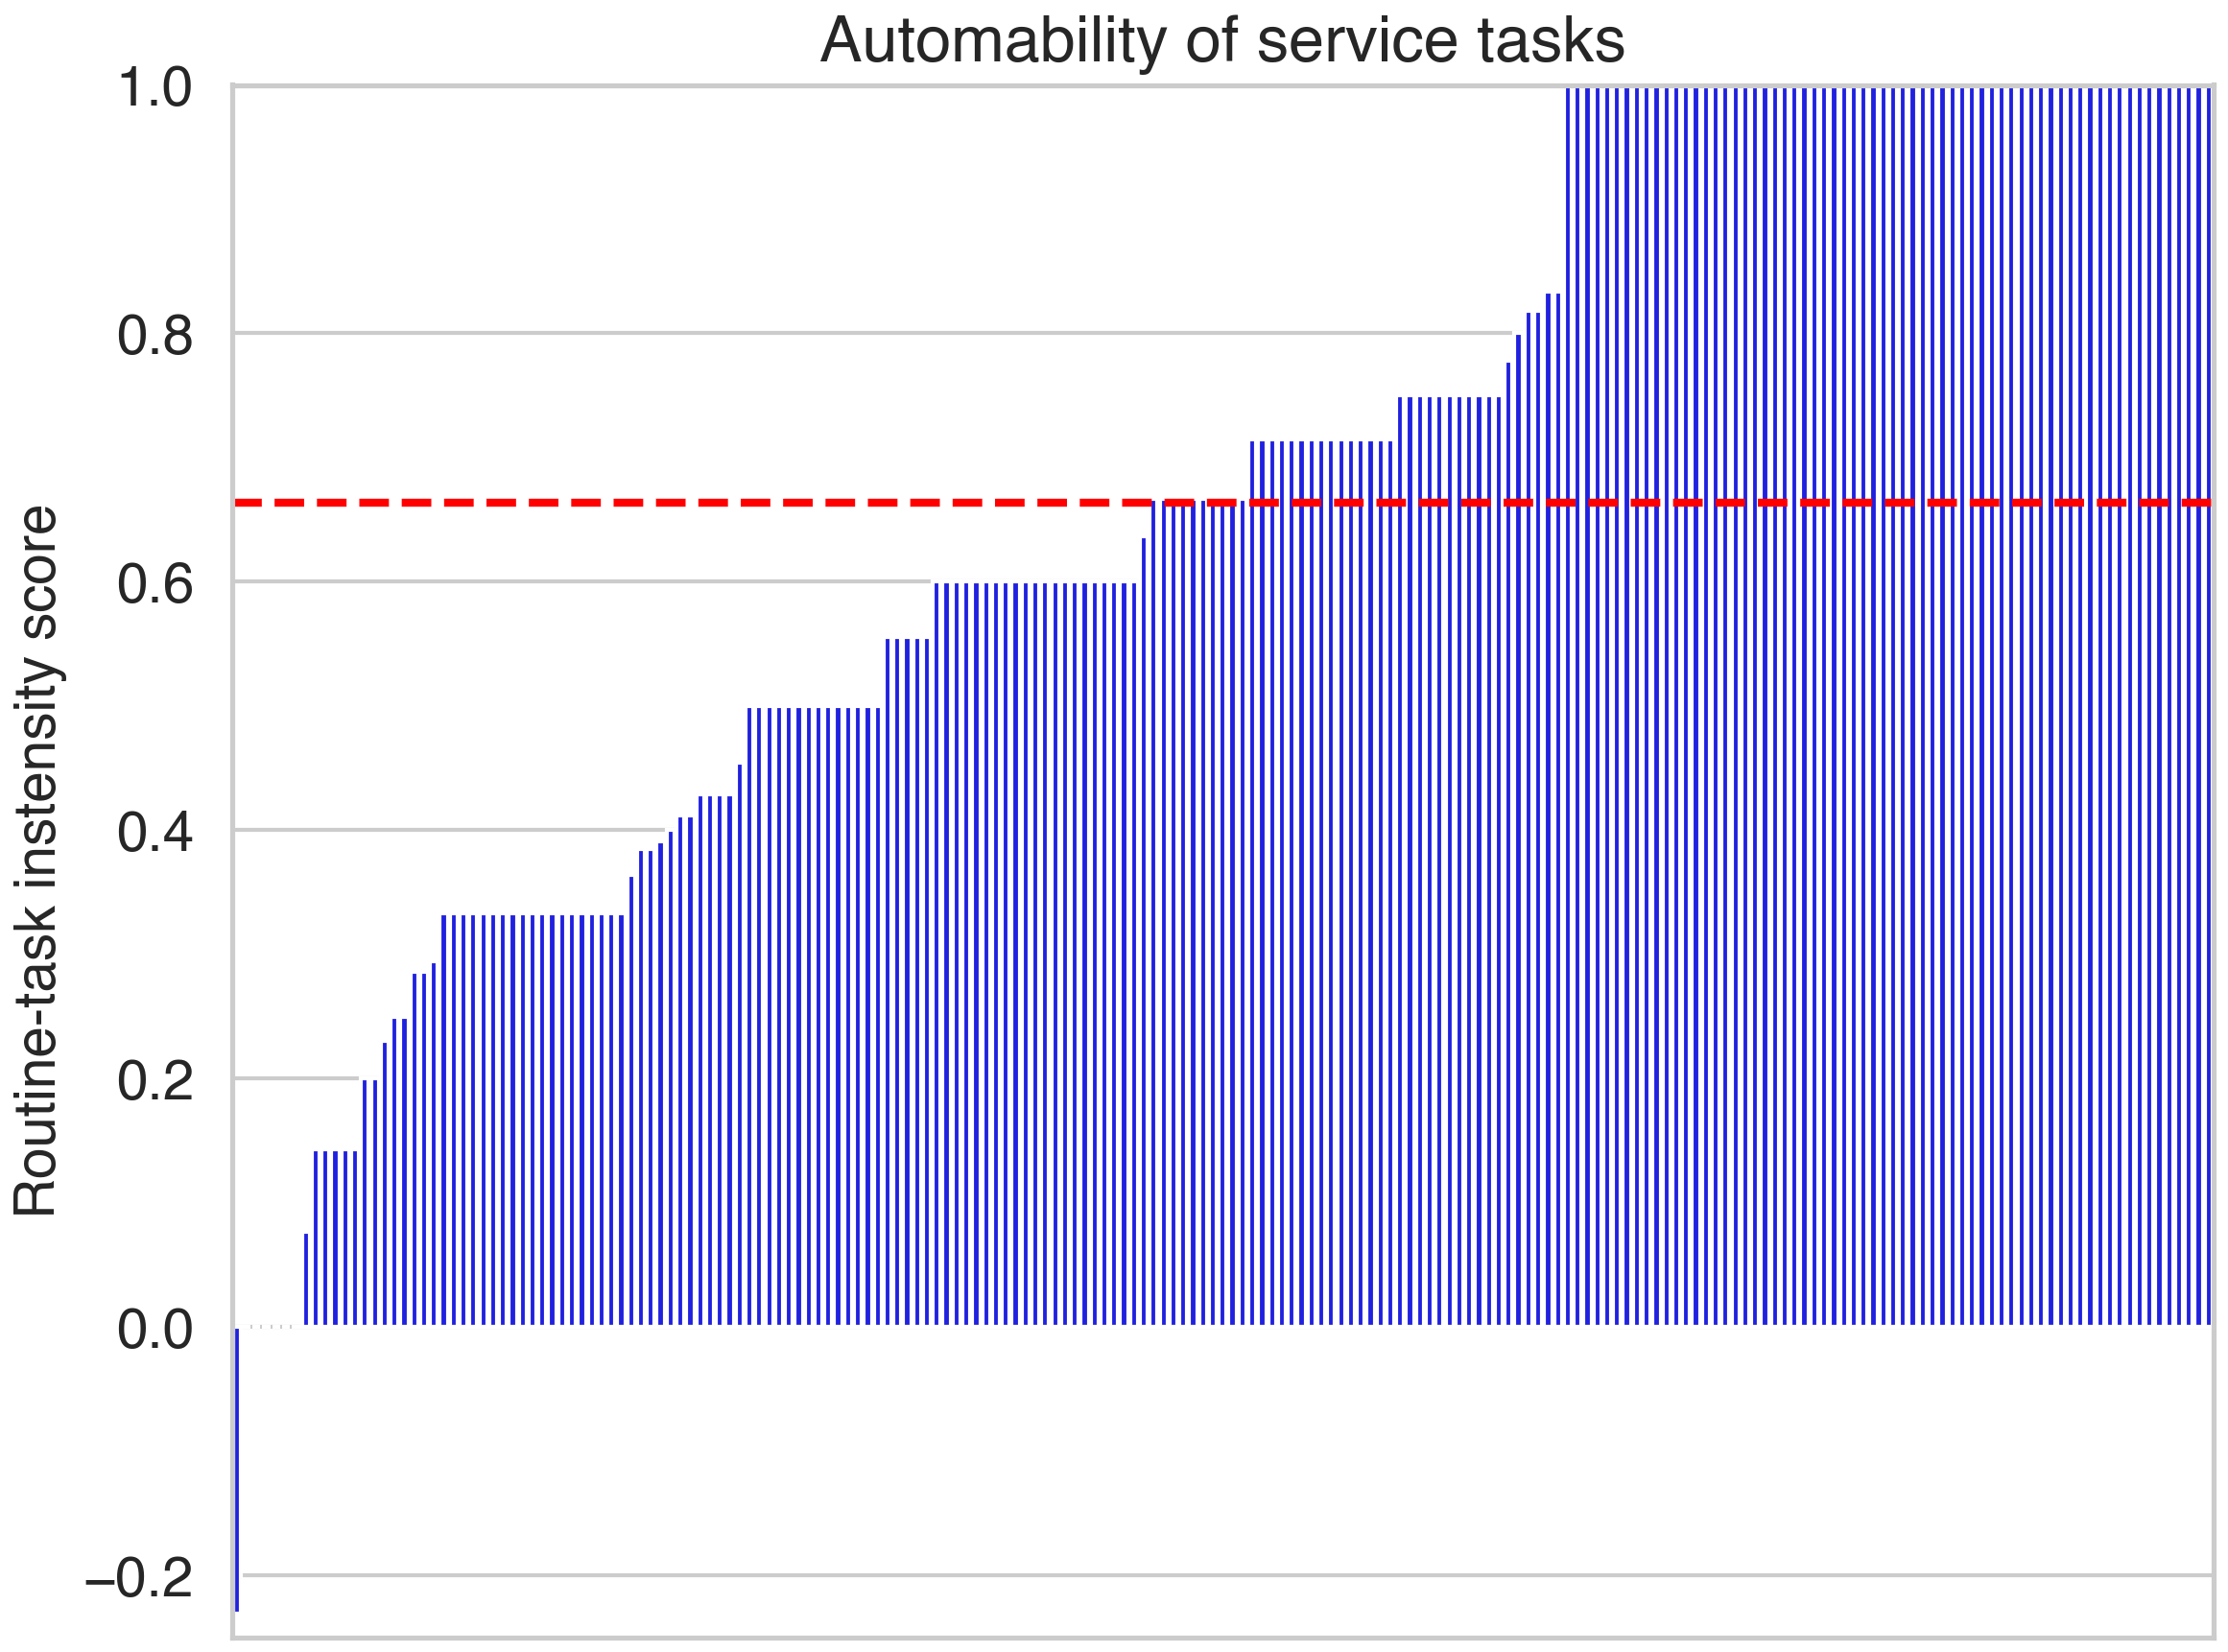

In [724]:
plot_service_distribution(analysis_df, metric='RTI', label='Automability of service tasks', xticks=False)